# WISDM Module Exam

### Instructions
Modify this notebook to compose your model. You may use additional `.py` files within this folder, `src/` for composing your framework.

### <span style="color:Orange;">  Table of Contents: </span>

I. Executive Summary

II. Problem Statement

III. Motivations

IV. Visualization

V. Deep Learning Model
  
VI. Result and discussion

VII. Conclusion and Recommendations

***

## <span style="color:Orange;"> I. Executive Summary </span>
`text here`

## <span style="color:Orange;"> II. Problem Statement </span>
`text here`

## <span style="color:Orange;"> III. Motivations </span>
`text here`

Importing Modules

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from datetime import datetime
from datetime import timedelta

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 40)   # displays max columns of the DataFrame 
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

To run the confusion matrix below:  
If module mixtend is not yet installed, download the module by copy-pasting this code `pip install mlxtend` to the terminal.

## The WISDM Dataset contains 18 different labels 

<b> Non-hand-oriented activities:  </b>  
{walking, jogging, stairs, standing, kicking}  
<b> Hand-oriented activities (General): </b>  
{dribbling, playing catch, typing, writing, clapping, brushing teeth, folding clothes}  
<b> Hand-oriented activities (eating):  </b>  
{eating pasta, eating soup, eating sandwich, eating chips, drinking}  



<span style="color:Cyan;"> In this activity, the group opt to use the accelerometer of each devices: phone and watch to predict an individual's activity. </span>

***


Reading and Loading the Data

In [4]:
# Main directory containing the dataset
main_directory = "C:/Users/User/Downloads/wisdm-dataset/raw"

# Subdirectories for phone and watch
phone_directory = os.path.join(main_directory, "phone", "accel")
watch_directory = os.path.join(main_directory, "watch", "accel")

In [6]:
# Function to load data from text files
def load_data(directory):
    data = []
    labels = []
    dates = []

    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                for line in file:
                    values = line.strip().split(',')
                    x, y, z = map(lambda v: float(v.replace(';', '')), values[-3:])
                    activity_label = values[1]        
                    date = values[2]   
                    data.append([x, y, z])
                    labels.append(activity_label)
                    dates.append(date)

    return np.array(data), np.array(labels), np.array(dates)

In [34]:
# Load data for phone and watch
phone_data, phone_labels, phone_time = load_data(phone_directory)
watch_data, watch_labels, watch_time = load_data(watch_directory)

In [35]:
# transforming into pd Series
y_accel_watch = pd.Series(watch_labels, name='labels')
y_accel_phone = pd.Series(phone_labels, name='labels')

In [111]:
X_accel_watch = pd.DataFrame(watch_data, columns=['x', 'y', 'z'])
X_accel_phone = pd.DataFrame(phone_data, columns=['x', 'y', 'z'])

# Adding more df
o_accel_watch_df = pd.concat([X_accel_watch, (pd.Series(watch_labels, name='labels'))], axis=1)
o_accel_phone_df = pd.concat([X_accel_phone, (pd.Series(phone_labels, name='labels'))], axis=1)

o_accel_watch_df = pd.concat([o_accel_watch_df, (pd.Series(watch_time, name='time'))], axis=1)
o_accel_phone_df = pd.concat([o_accel_phone_df, (pd.Series(phone_time, name='time'))], axis=1)

```
# transforming time into seconds
o_accel_phone_df['time'] = o_accel_phone_df['time'] / 10**6
o_accel_phone_df['time'] = datetime.datetime.fromtimestamp(o_accel_phone_df['time'])

```

In [112]:
# for a more balanced data
def filter_and_head(df, labels, n_samples):
    filtered_data = {}
    for label in labels:
        filtered_data[label] = df[df['labels'] == label].head(n_samples).copy()
    return filtered_data

In [113]:
# Define the labels
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'O', 'P', 'Q', 'R', 'S']

# Call the function to filter and select the first 203112 rows for each label
filtered_phone_data = filter_and_head(o_accel_phone_df, labels, 203112)
filtered_watch_data = filter_and_head(o_accel_watch_df, labels, 203112)

# Concatenate the DataFrames from the filtered data
balanced_phone_data = pd.concat(filtered_phone_data.values(), ignore_index=True)
balanced_watch_data = pd.concat(filtered_watch_data.values(), ignore_index=True)

In [114]:
# Dictionary mapping labels to corresponding names
label_names = {
    'A': 'Walking',
    'B': 'Jogging',
    'C': 'Stairs',
    'D': 'Sitting',
    'E': 'Standing',
    'F': 'Typing',
    'G': 'Brushing Teeth',
    'H': 'Eating Soup',
    'I': 'Eating Chips',
    'J': 'Eating Pasta',
    'K': 'Drinking from Cup',
    'L': 'Eating Sandwich',
    'M': 'Kicking (Soccer Ball)',
    'O': 'Playing Catch w/Tennis Ball',
    'P': 'Dribbling (Basketball)',
    'Q': 'Writing',
    'R': 'Clapping',
    'S': 'Folding Clothes'
}

# Set labels based on the corresponding names
o_accel_phone_df['activities'] = o_accel_phone_df['labels'].map(label_names)
o_accel_watch_df['activities'] = o_accel_watch_df['labels'].map(label_names)

## <span style="color: Orange;"> II. Visualization </span>

In [119]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15,7), sharex=True)
    plot_axis(ax0, data['time'], data['x'], 'x-axis')
    plot_axis(ax1, data['time'], data['y'], 'y-axis')
    plot_axis(ax2, data['time'], data['z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_ylim([min(y), max(y)]) 
    ax.grid(True)

In [59]:
Fs = 20

### Accelerometer Phone Plot 

In [110]:
o_accel_phone_df.head(3)

x          y         z labels             time activities
0 -0.364761   8.793503  1.055084      A  252207666810782    Walking
1 -0.879730   9.768784  1.016998      A  252207717164786    Walking
2  2.001495  11.109070  2.619156      A  252207767518790    Walking

In [120]:
activities = o_accel_phone_df['activities'].value_counts().index

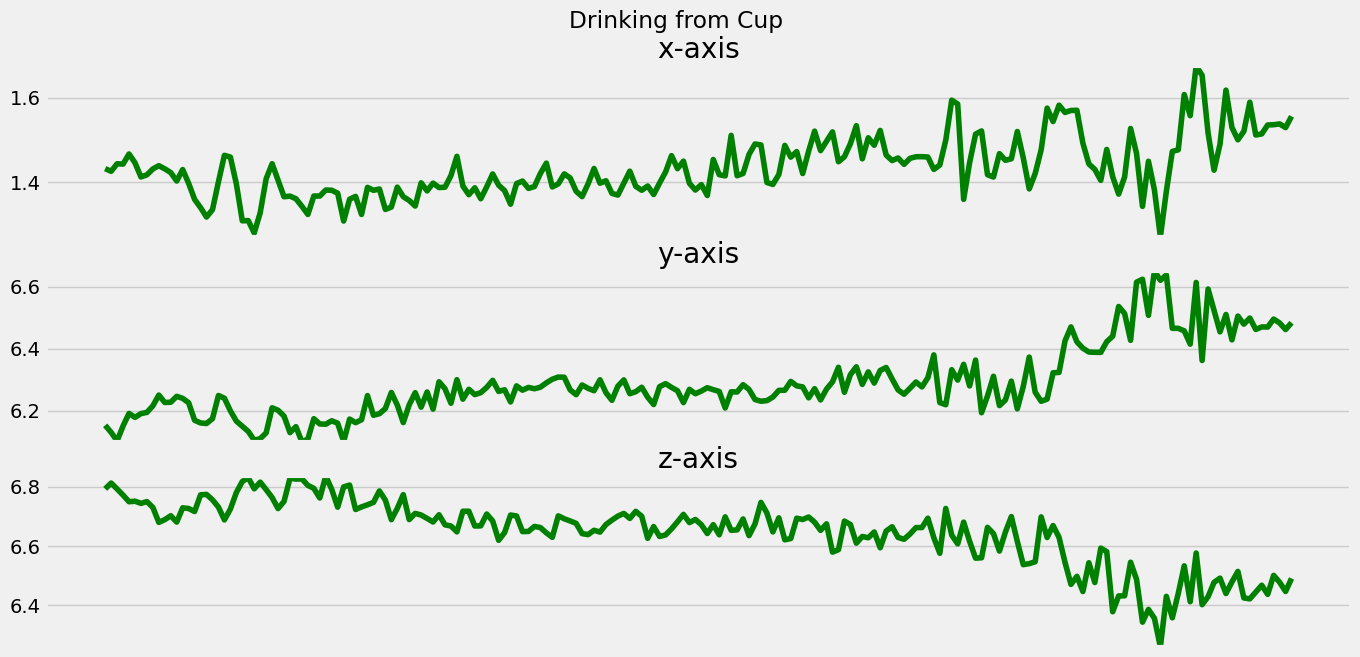

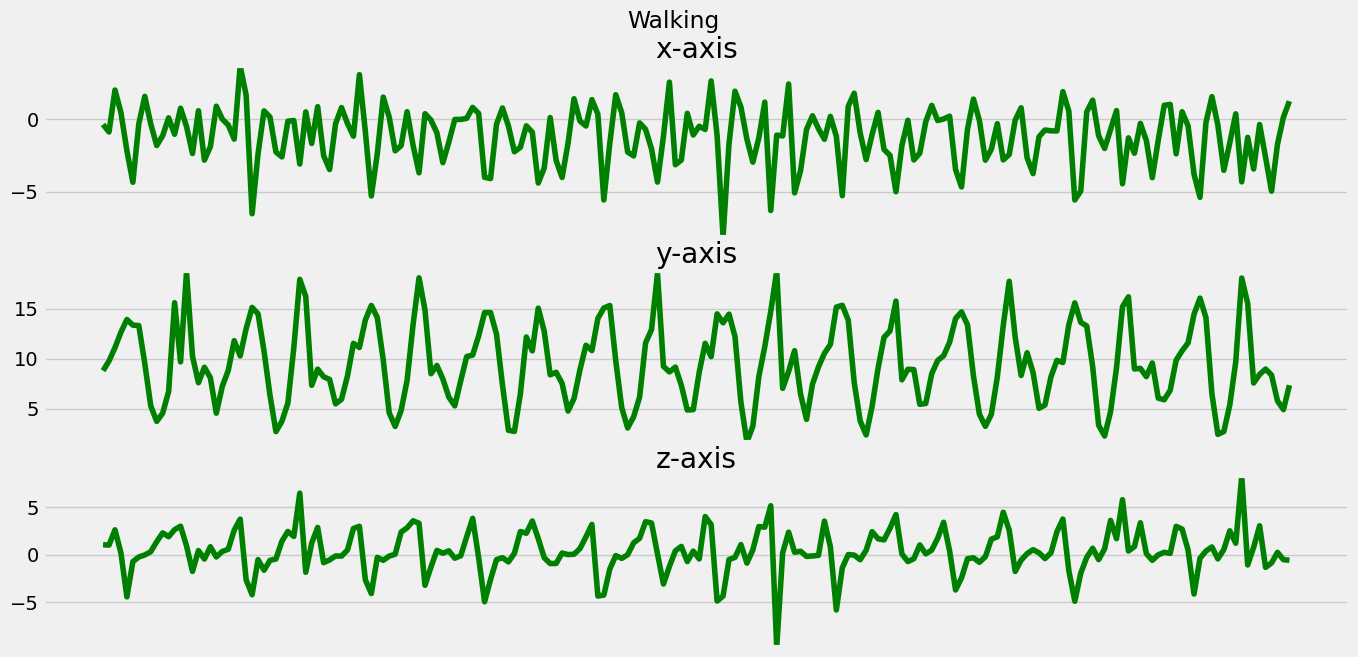

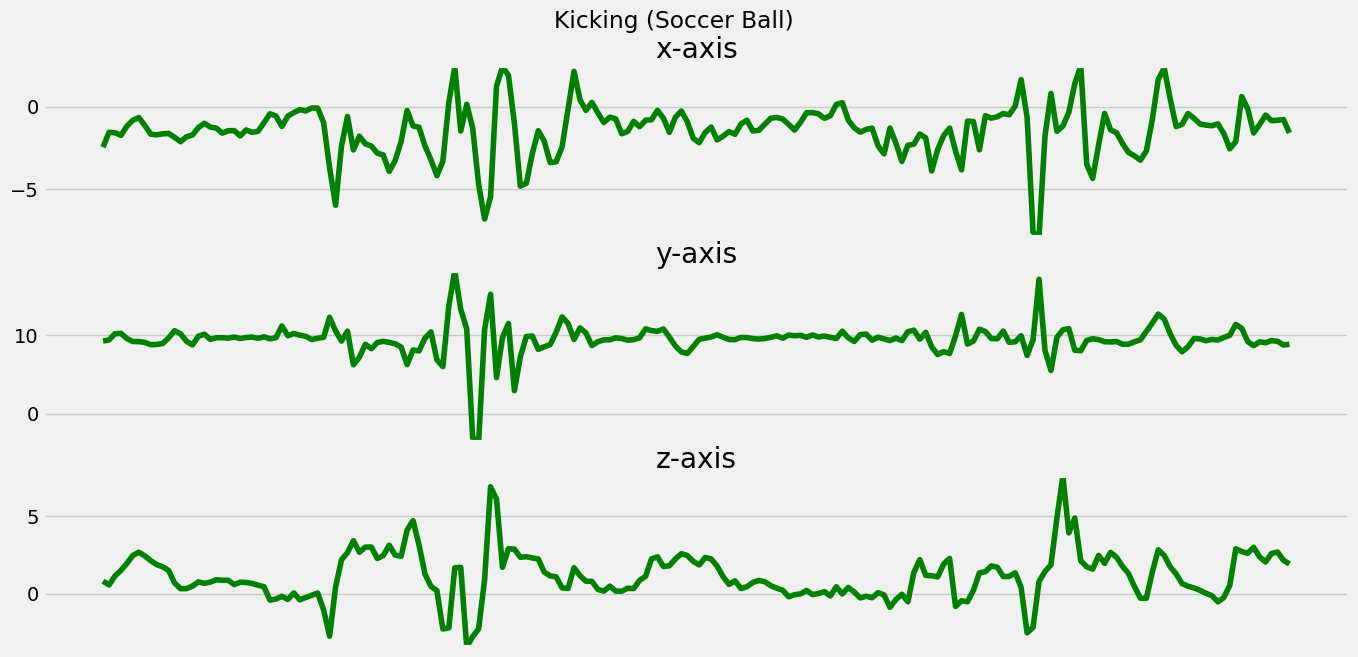

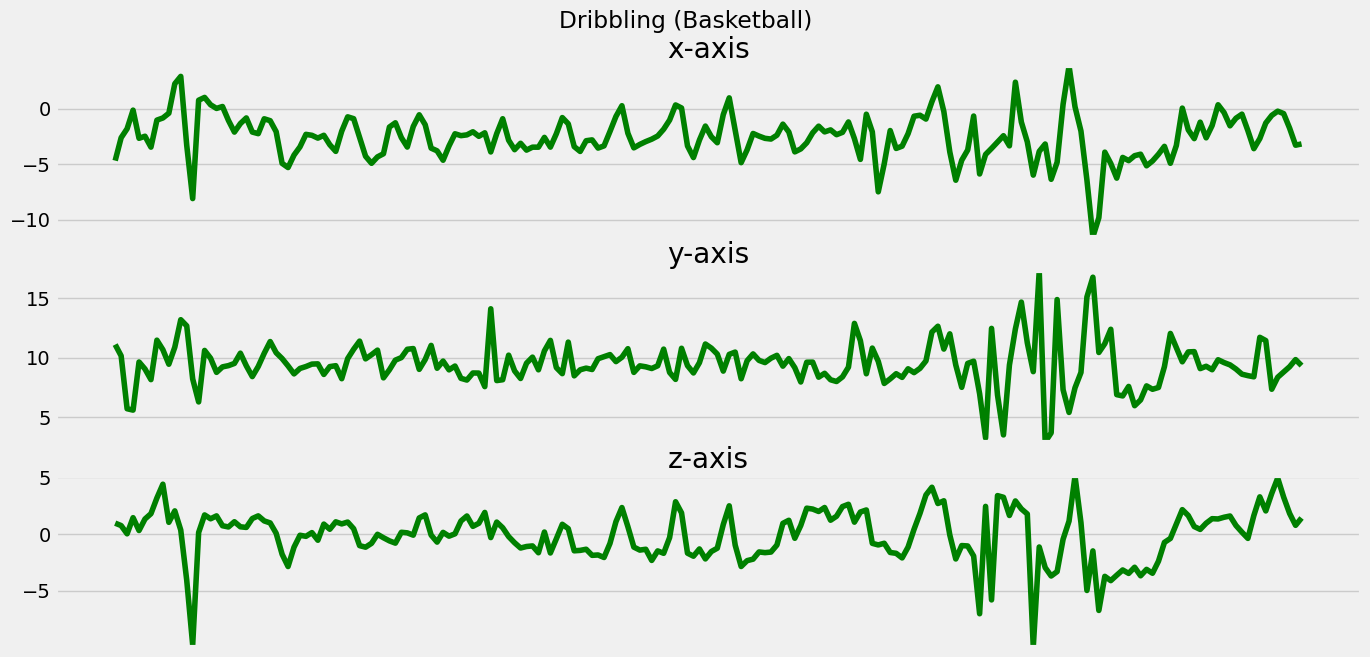

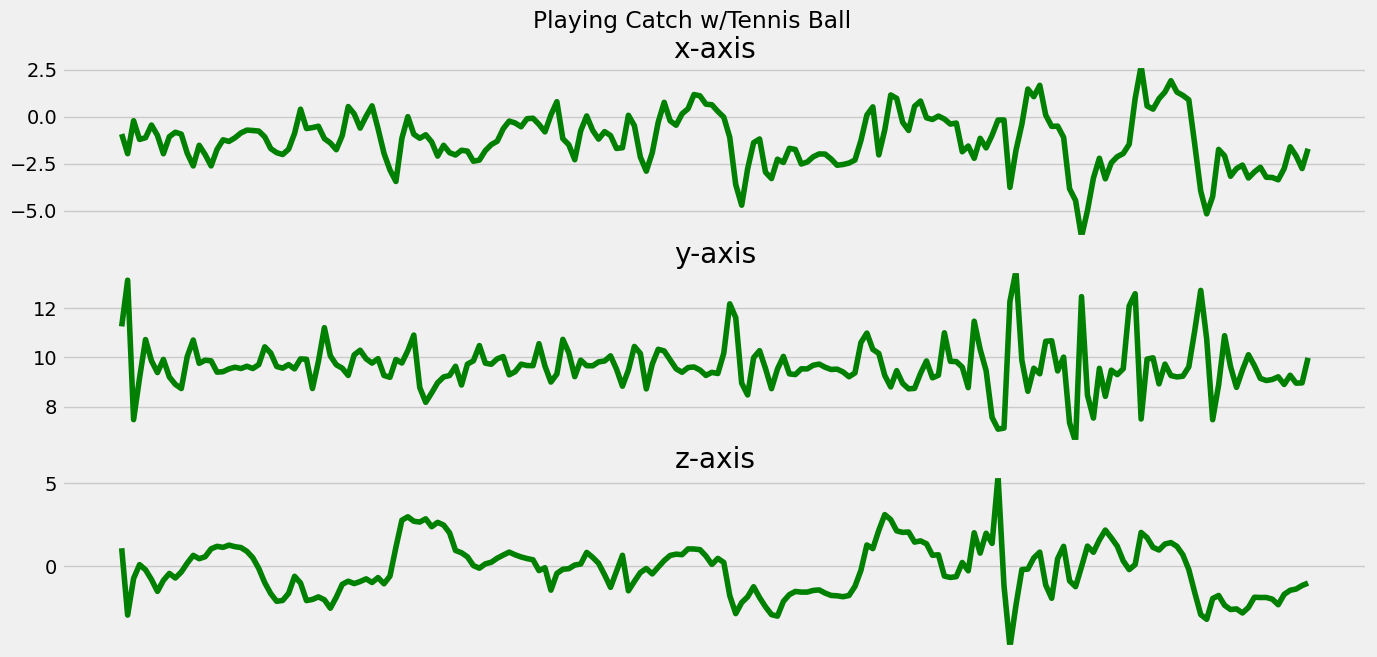

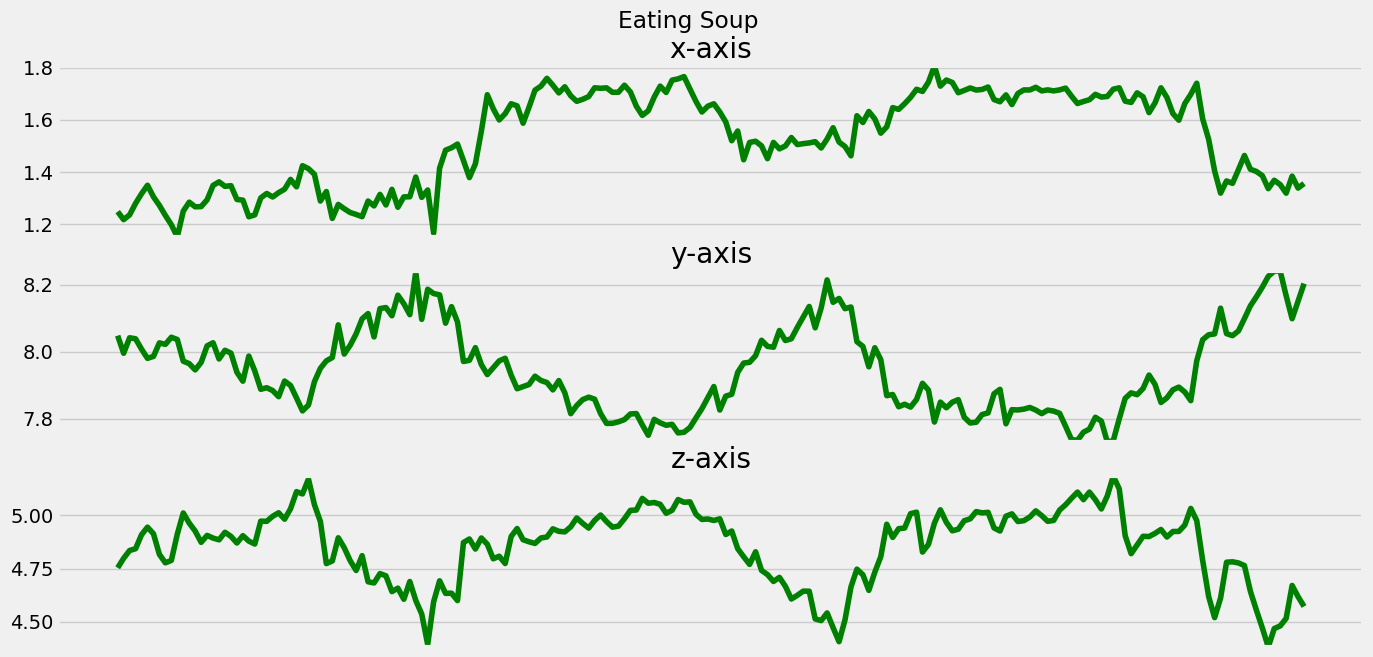

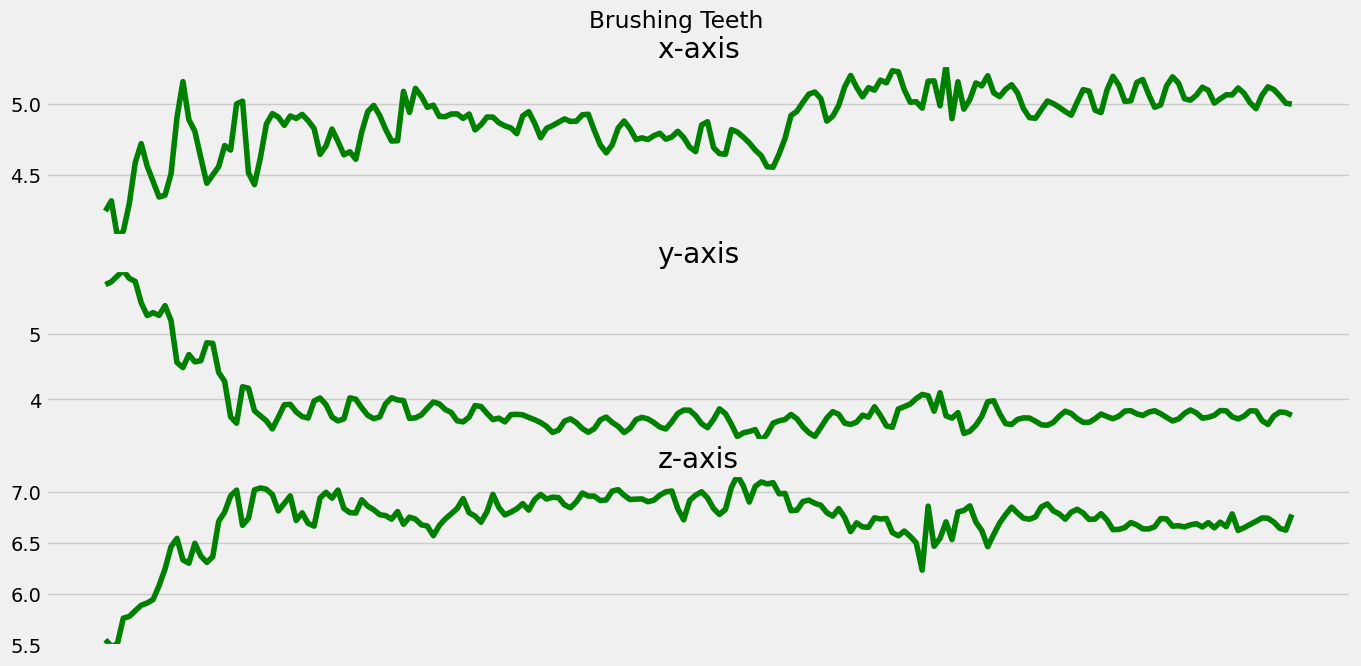

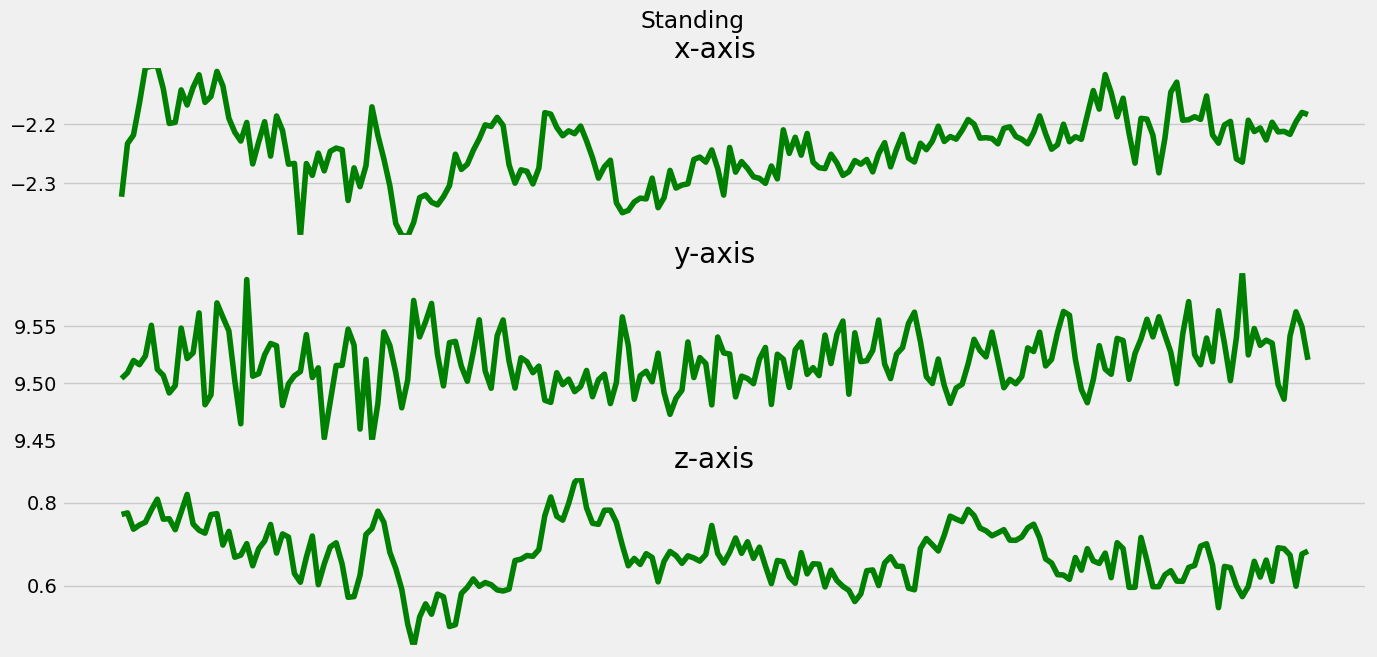

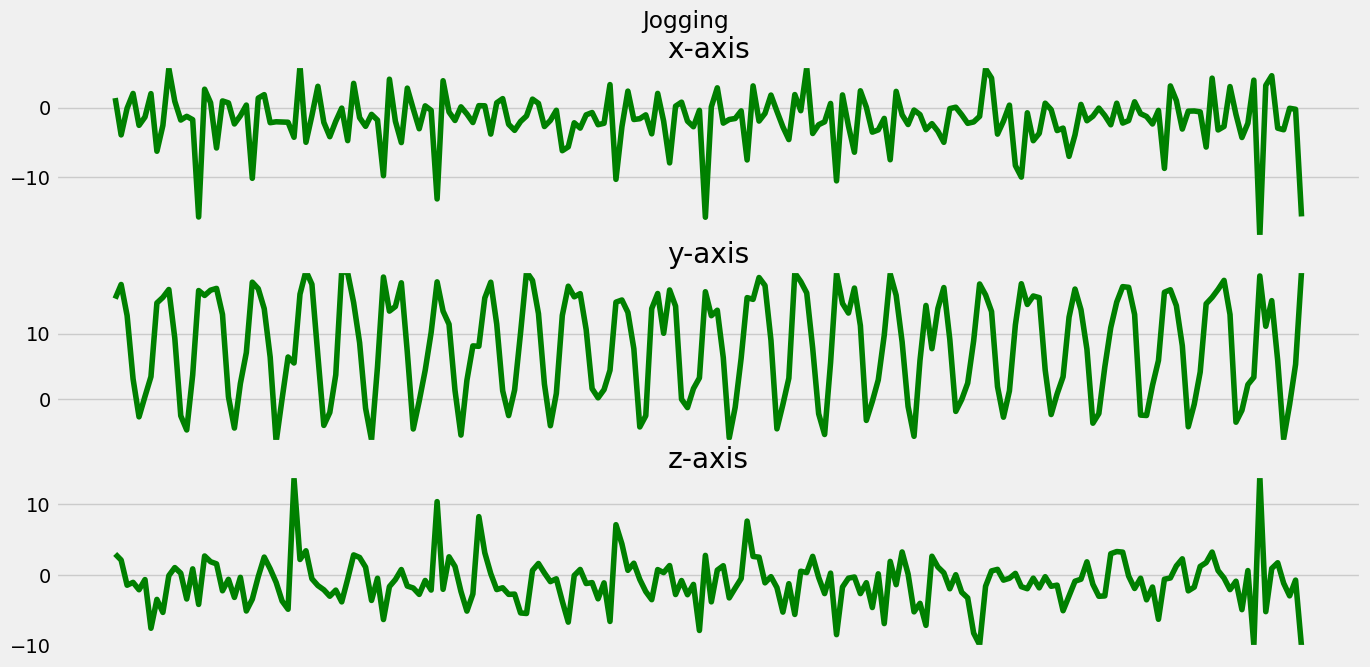

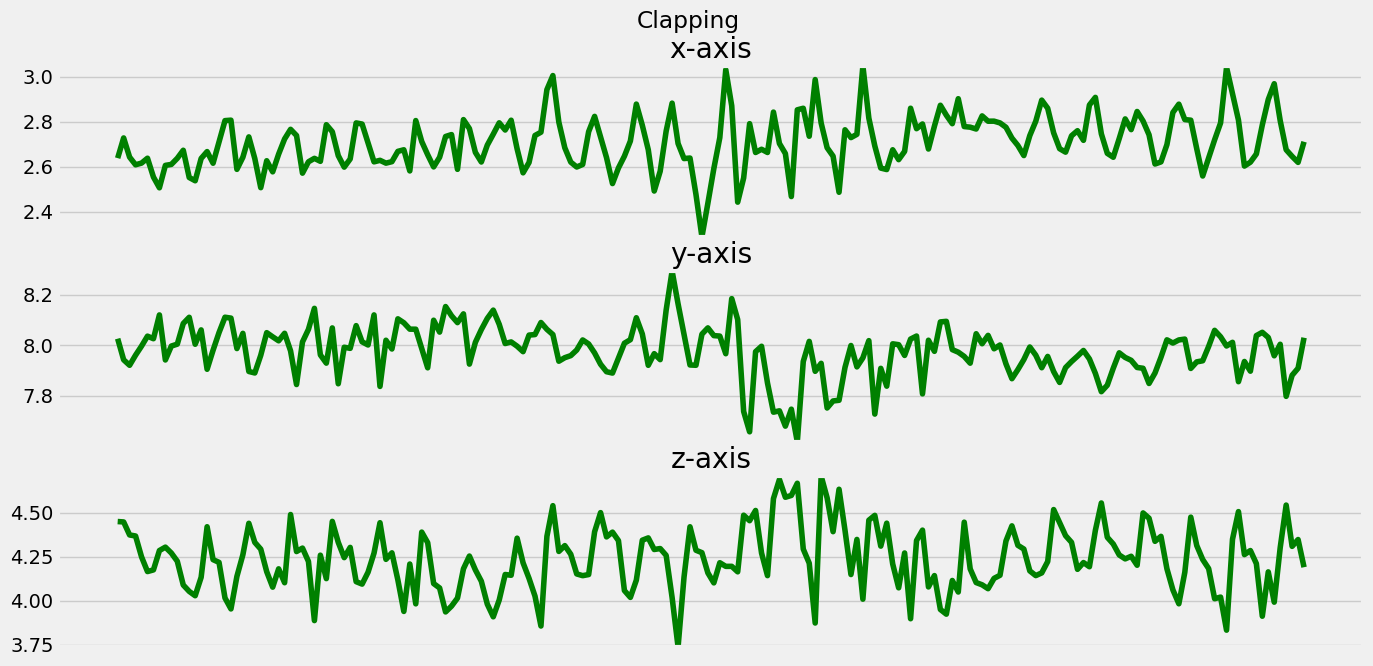

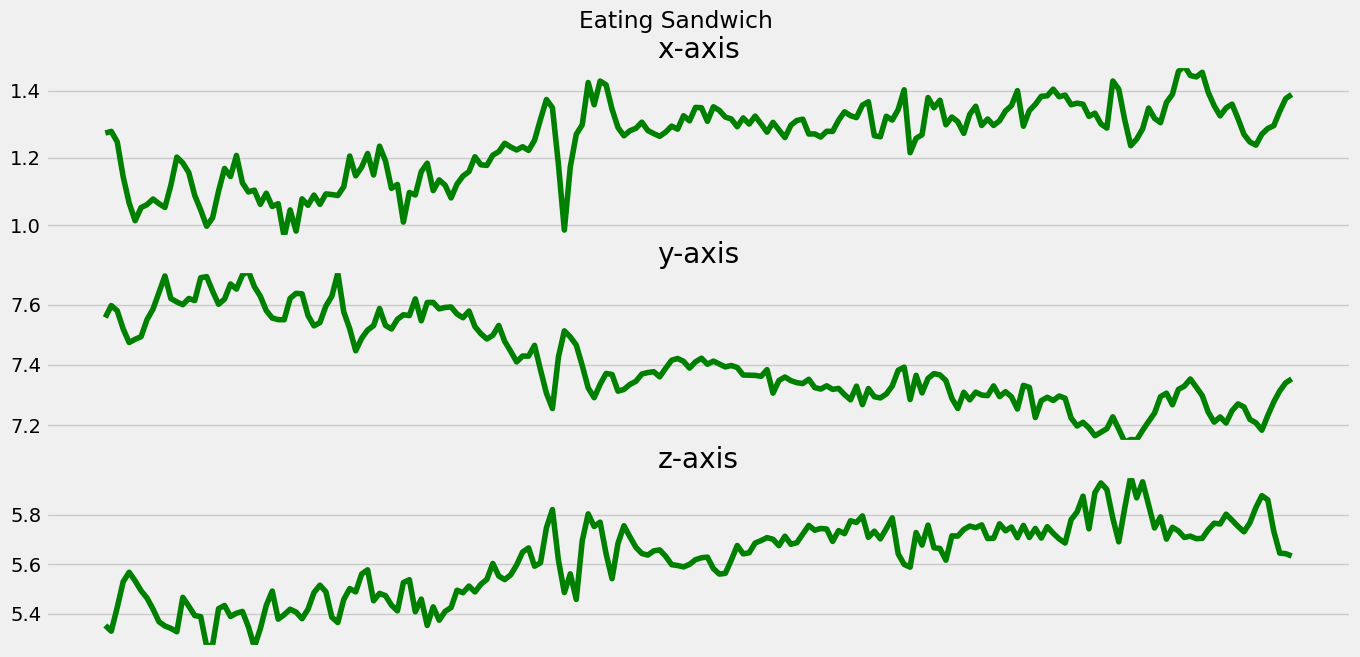

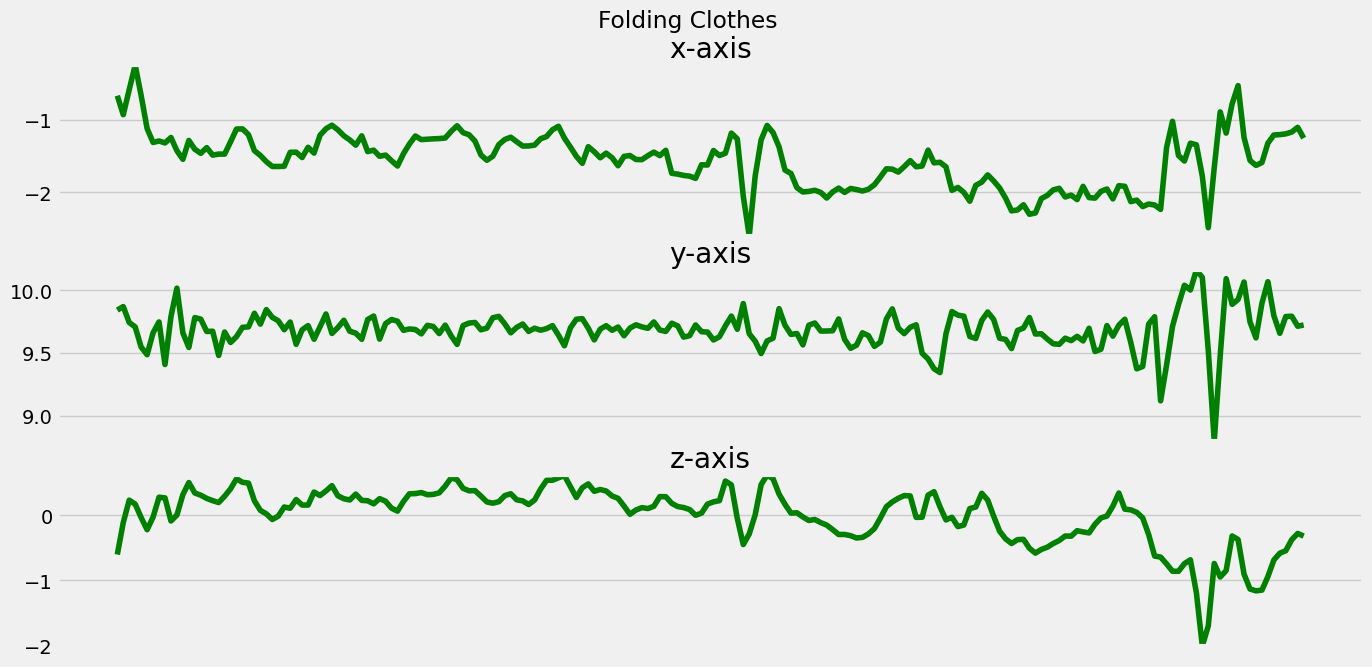

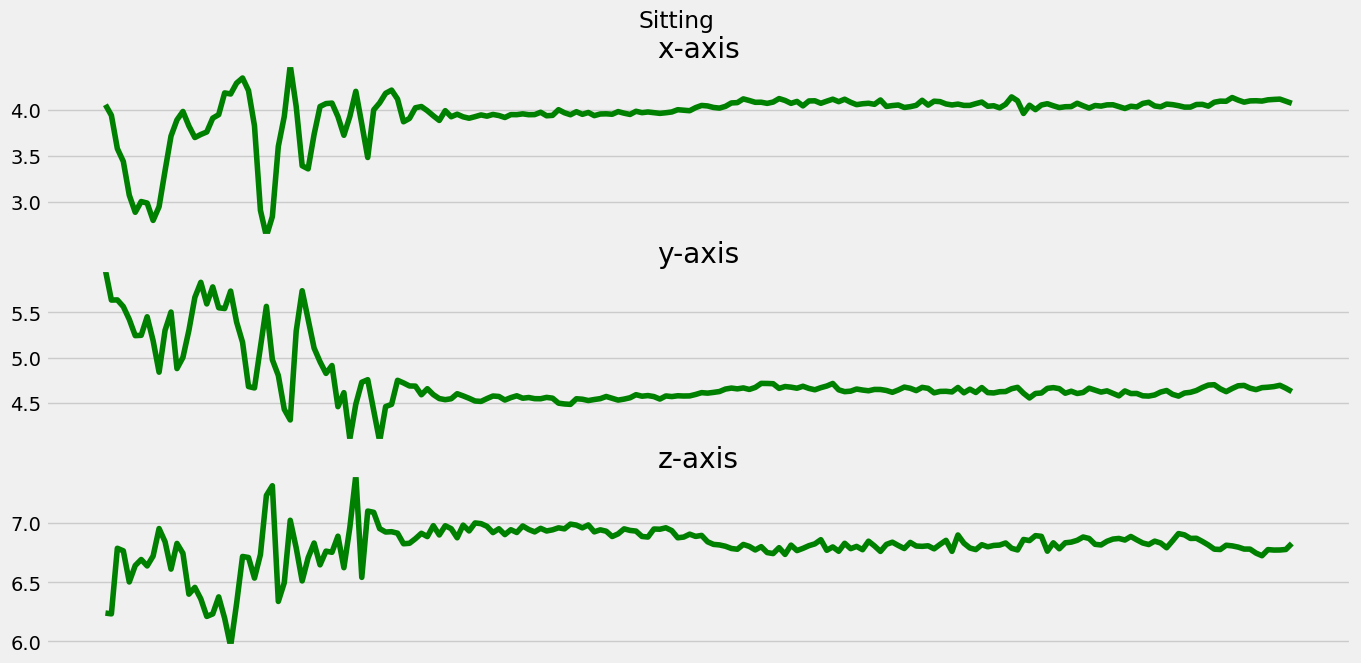

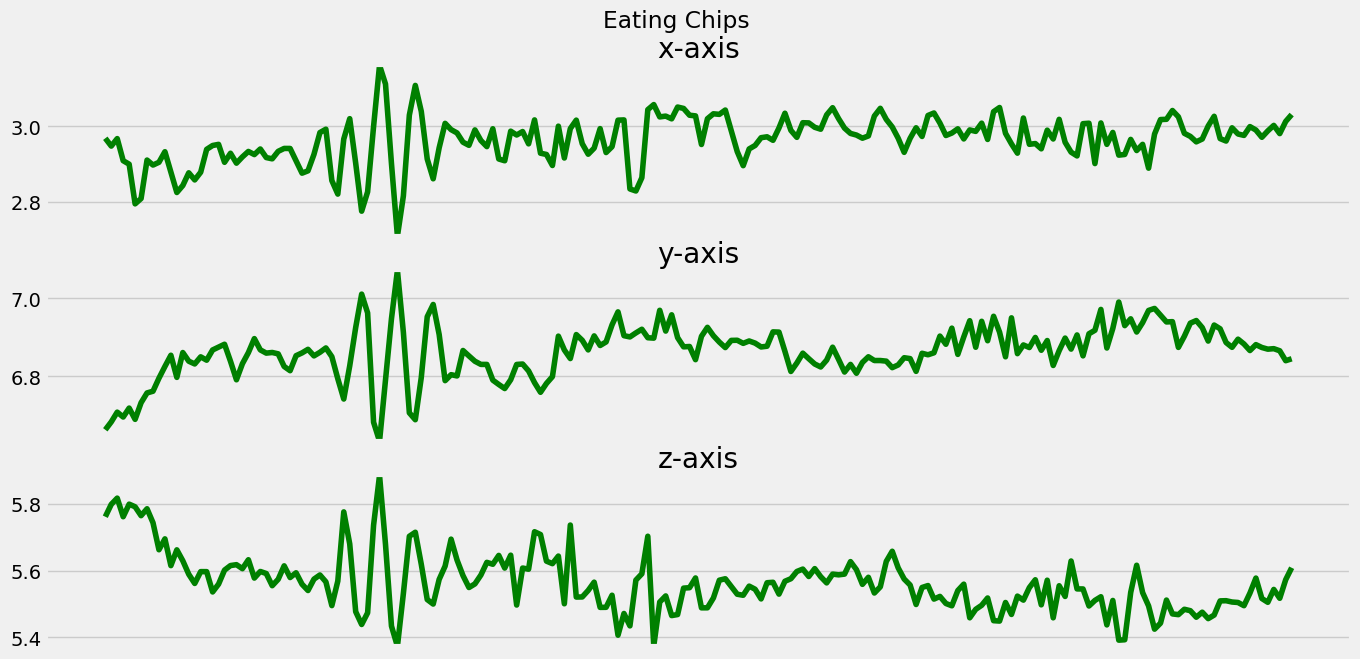

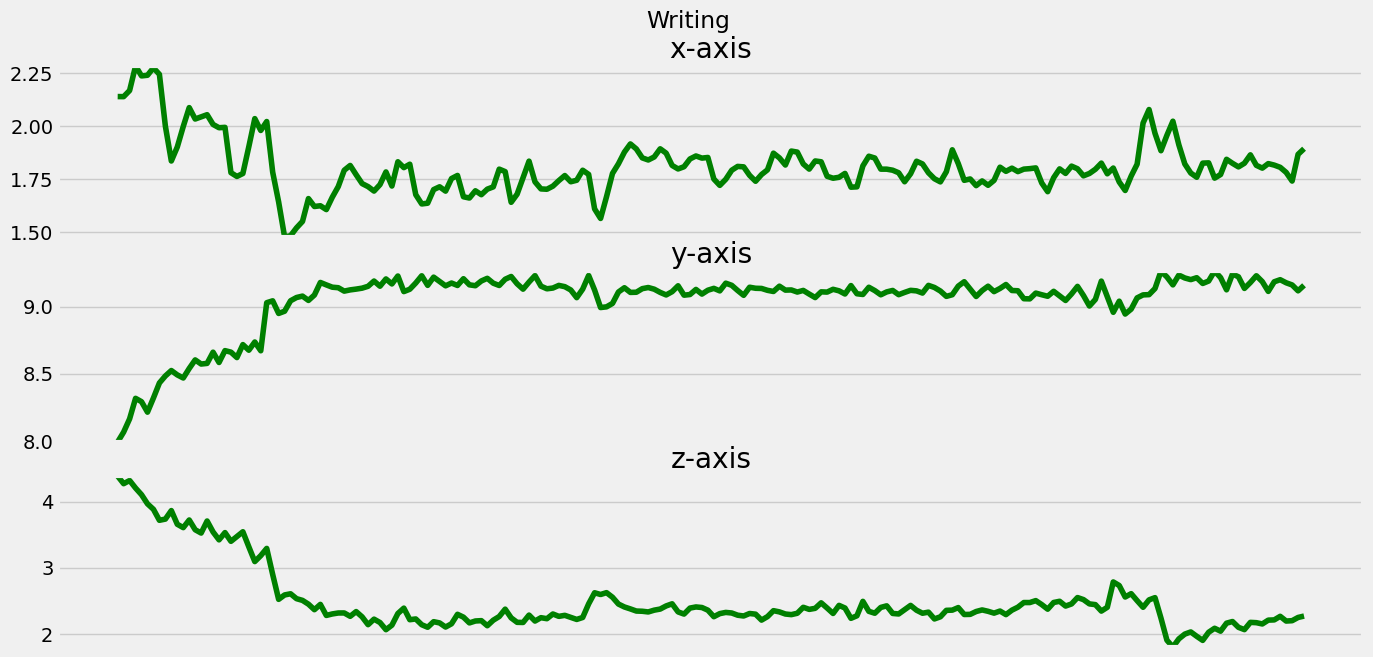

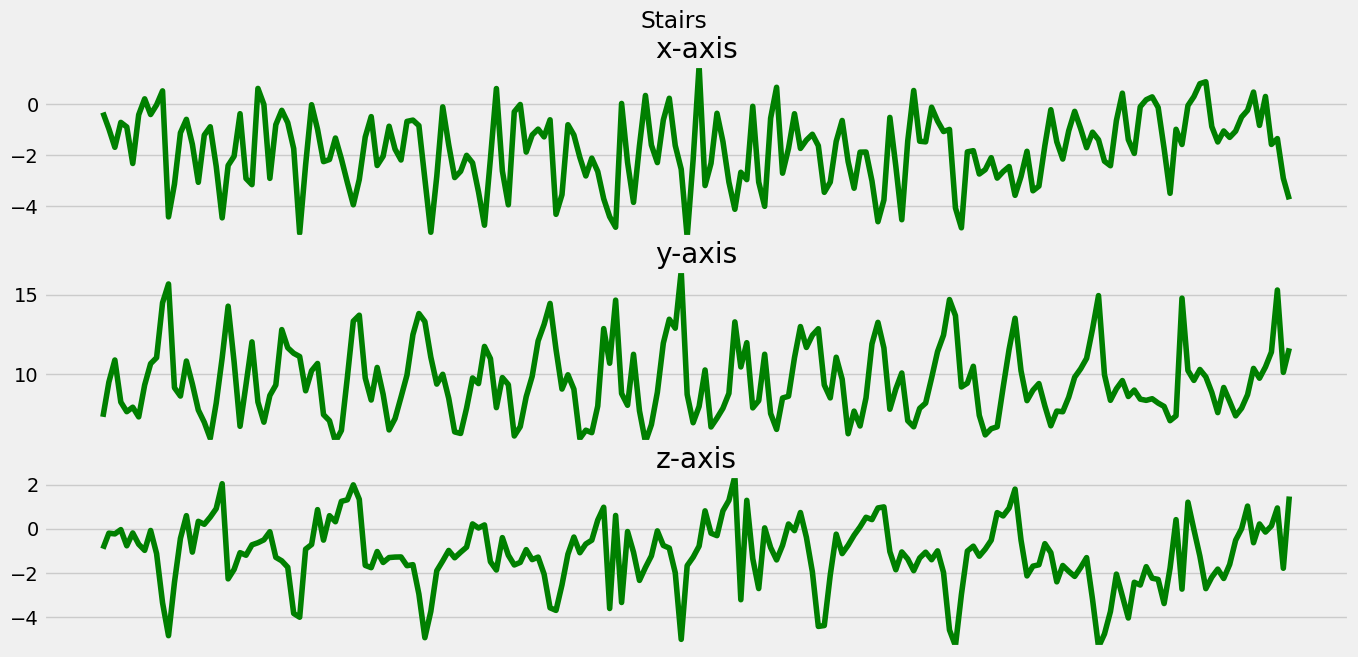

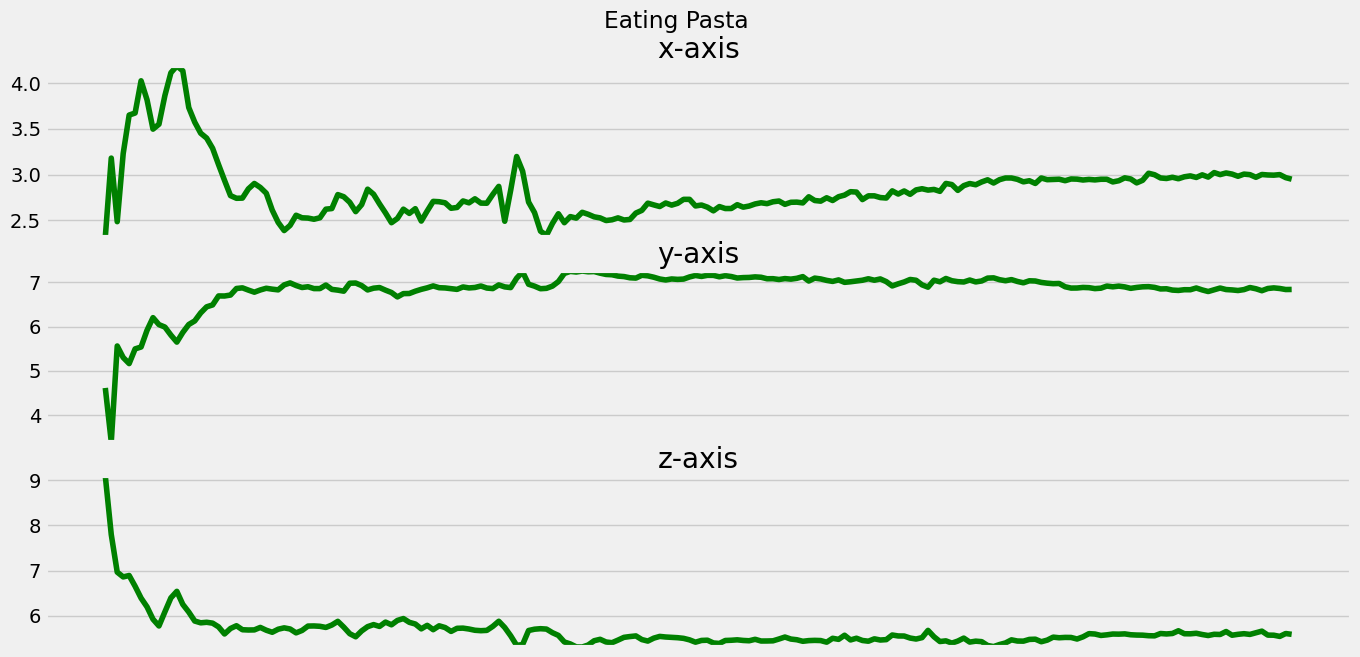

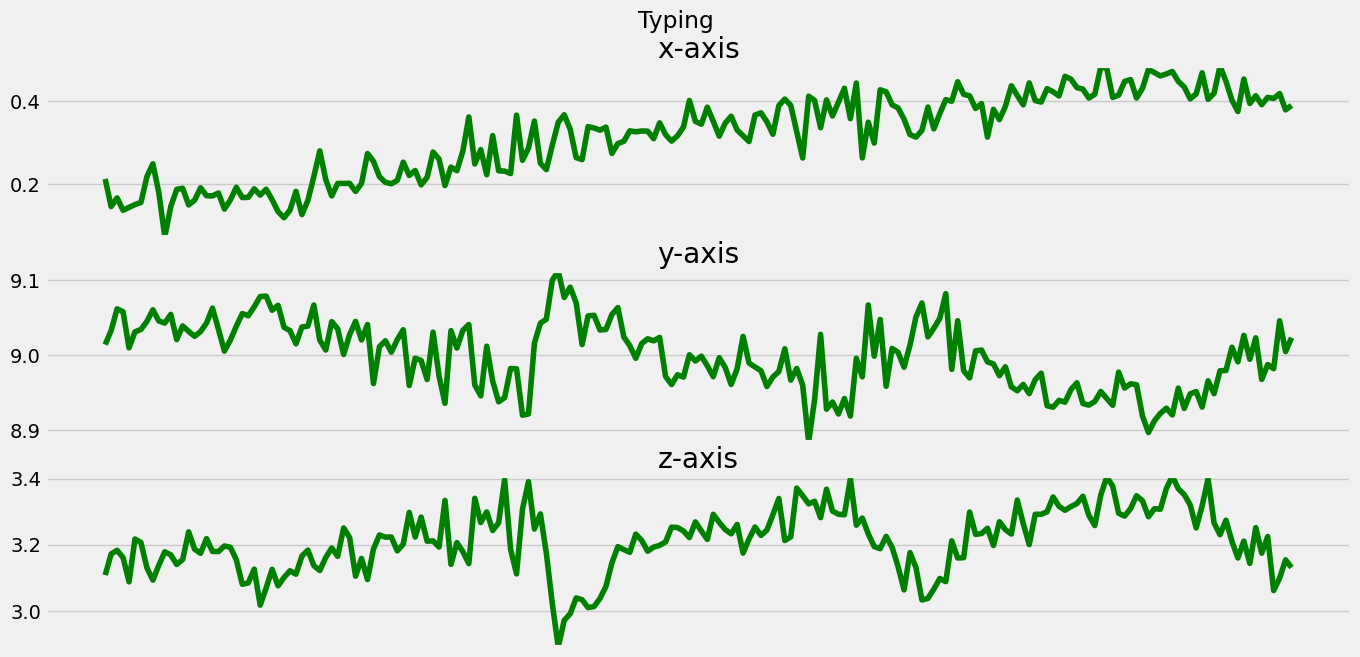

In [118]:
for activity in activities:
    data_for_plot = o_accel_phone_df[o_accel_phone_df['activities'] == activity][:Fs * 10]
    plot_activity(activity, data_for_plot)

### Accelerometer Watch Plot

In [121]:
o_accel_watch_df.head(3)

x         y         z labels            time activities
0  7.091625 -0.591667  8.195502      A  90426708196641    Walking
1  4.972757 -0.158317  6.696732      A  90426757696641    Walking
2  3.253720 -0.191835  6.107758      A  90426807196641    Walking

In [122]:
activities = o_accel_watch_df['activities'].value_counts().index

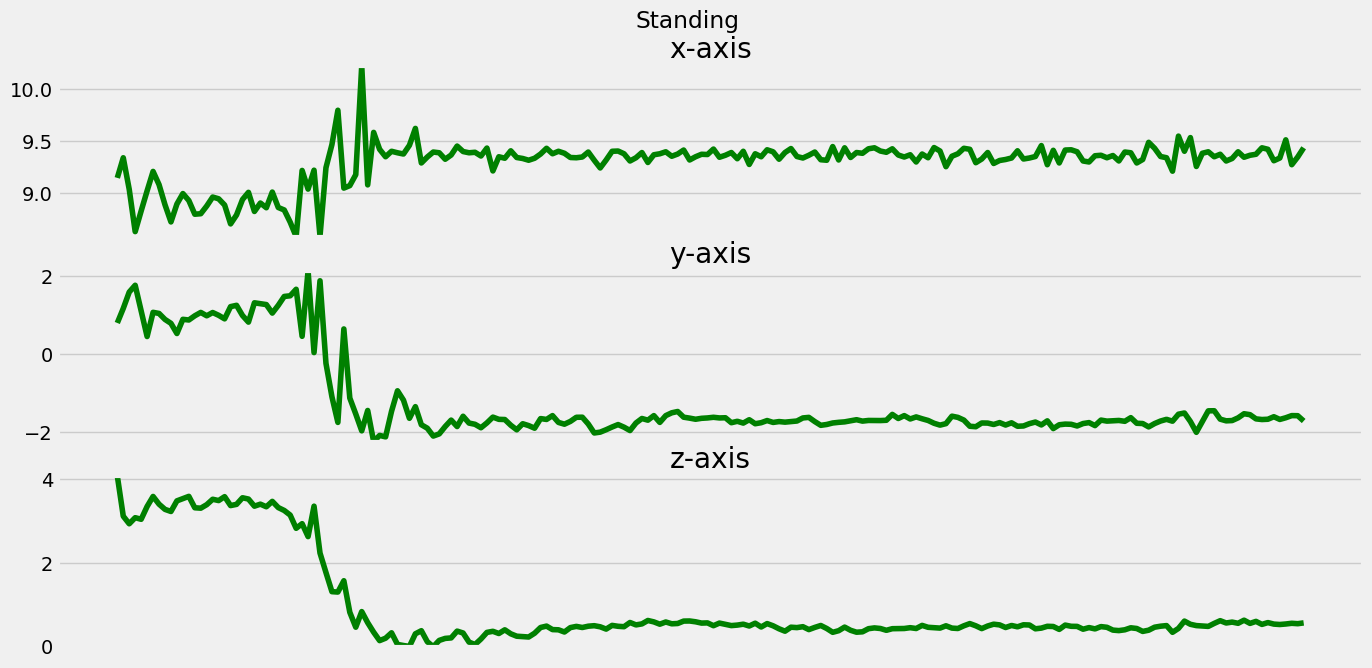

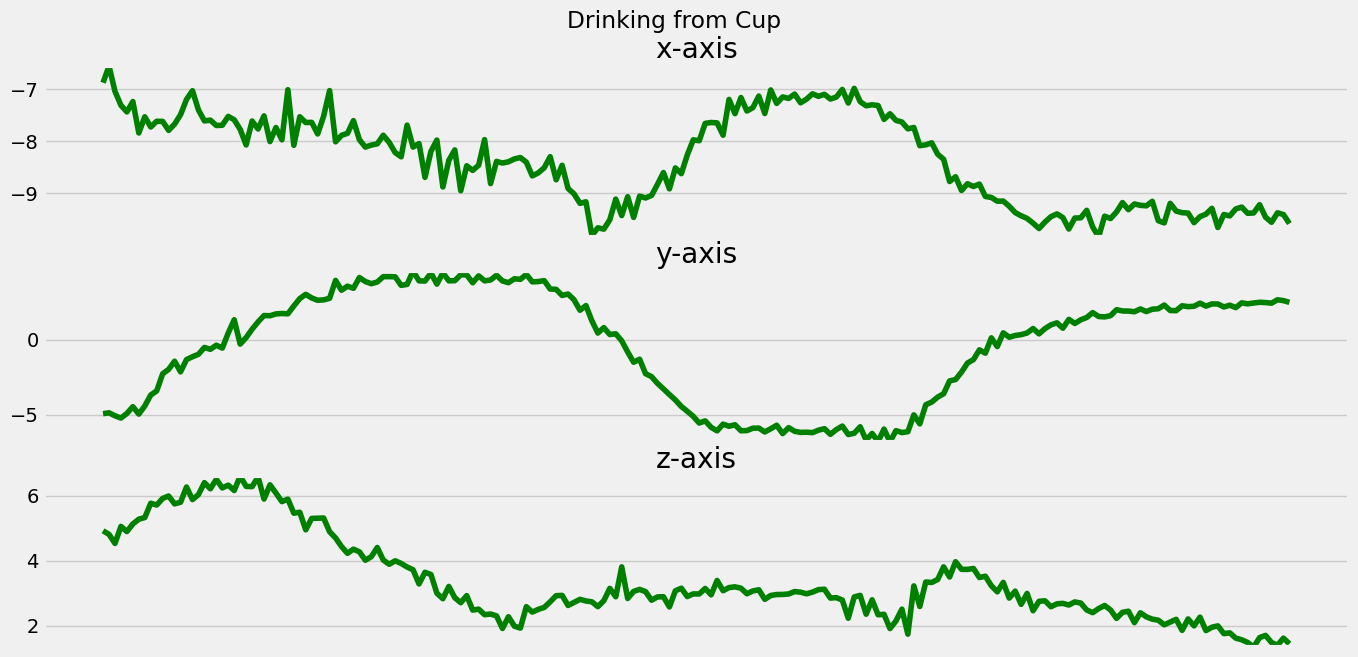

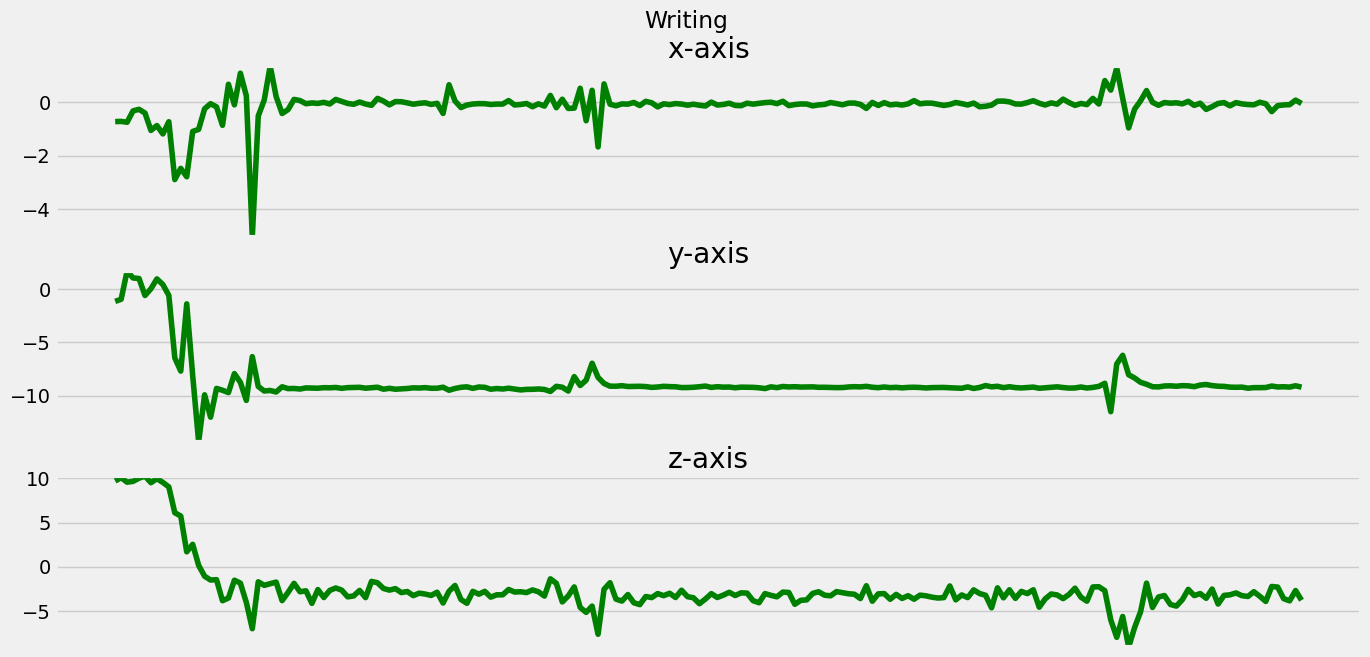

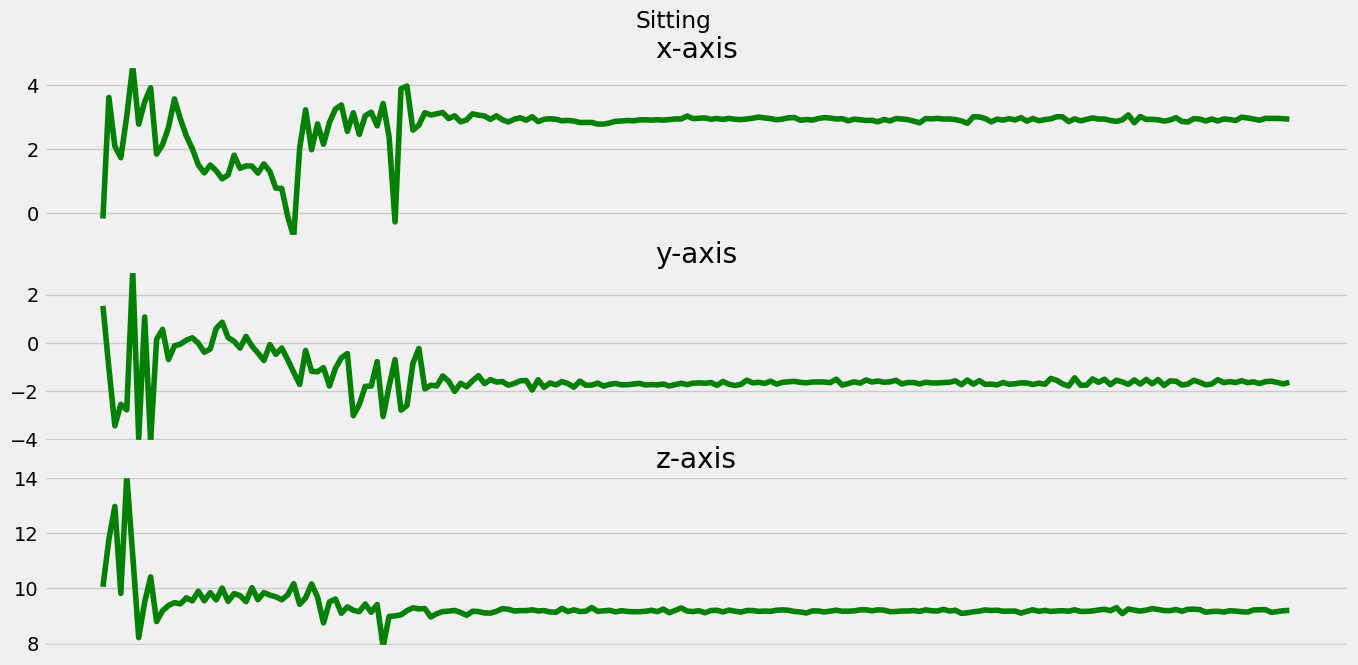

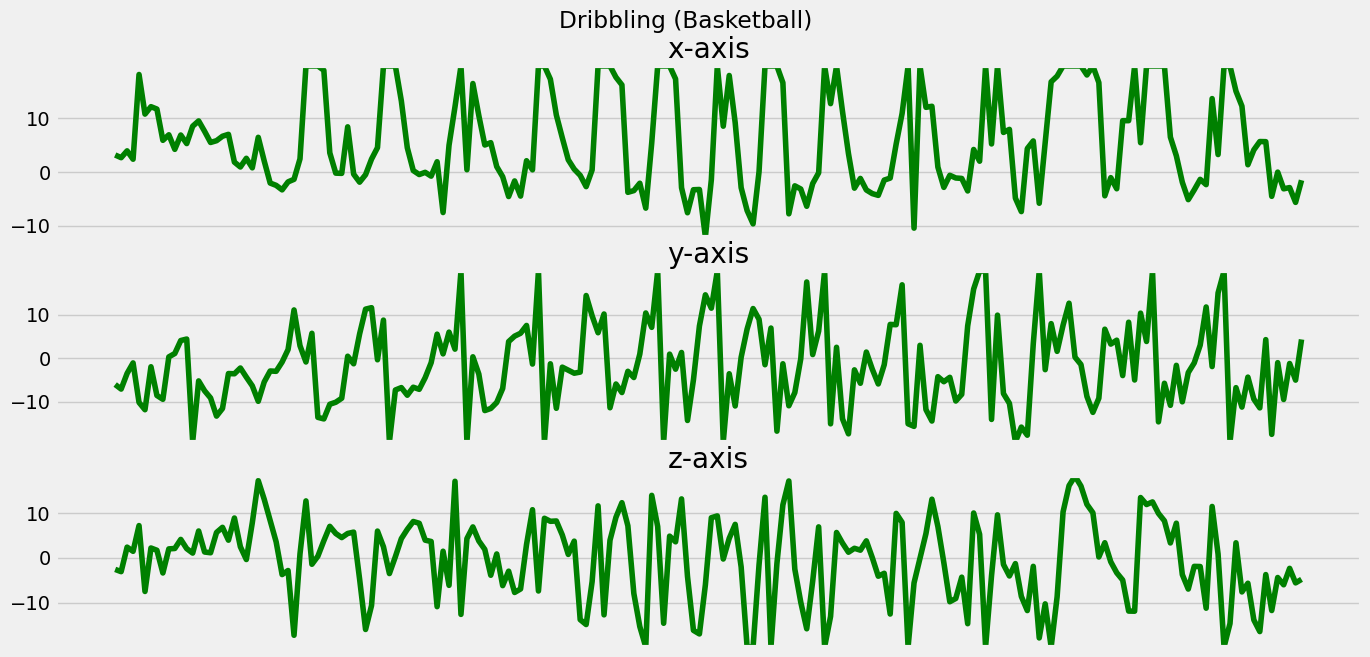

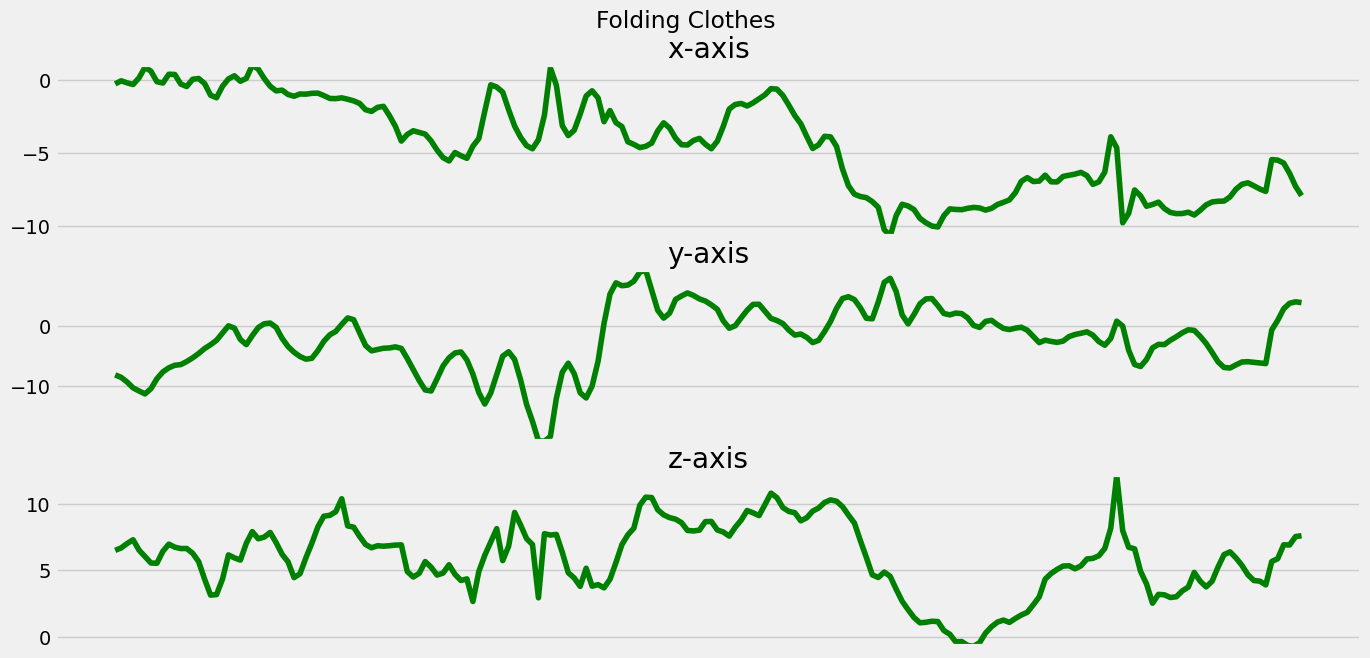

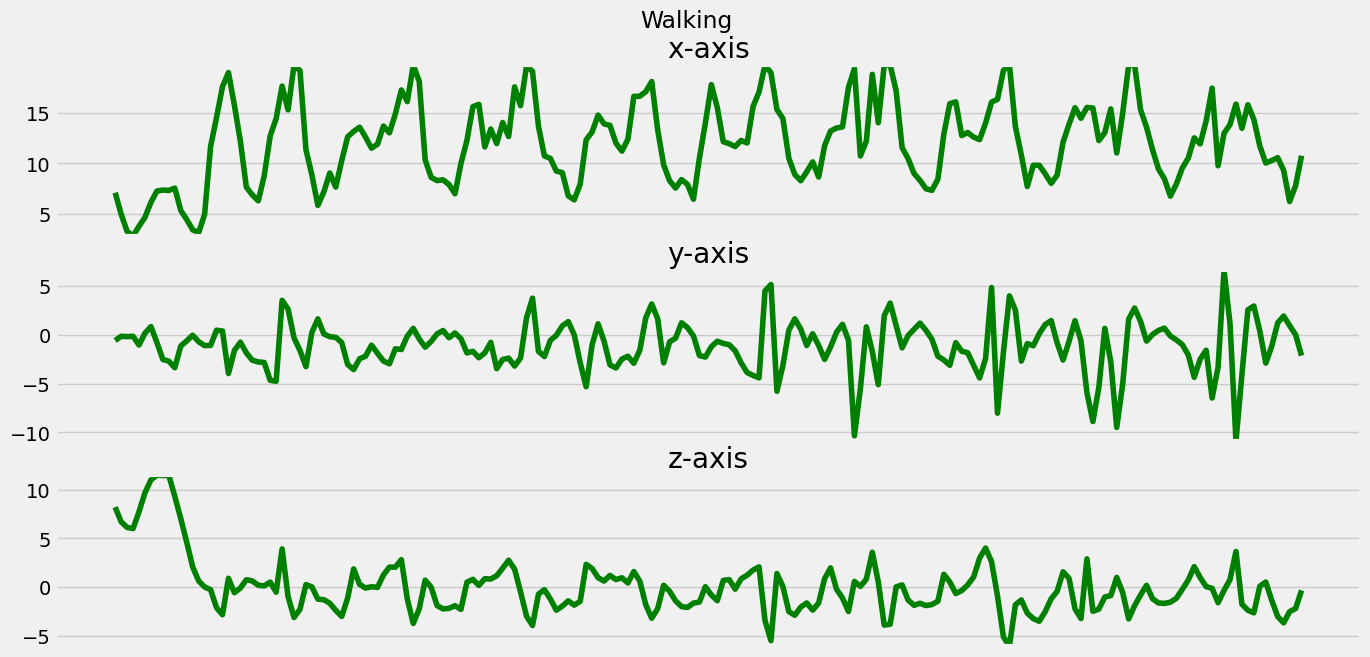

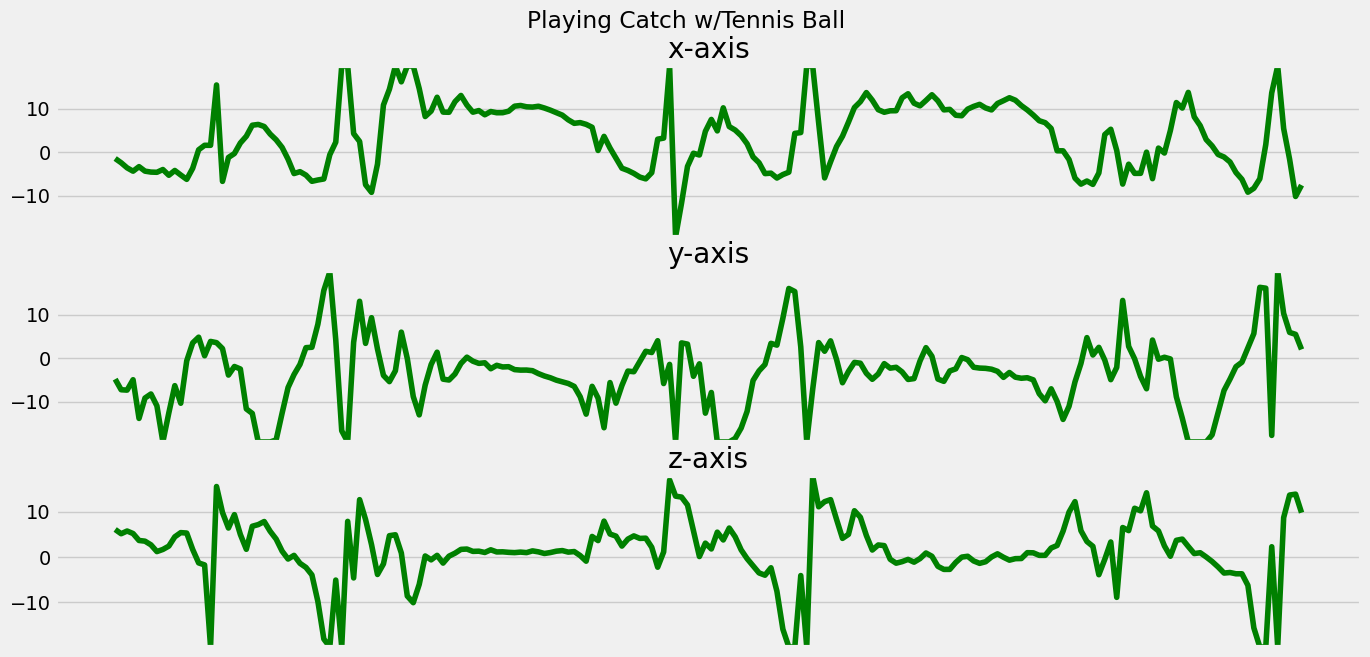

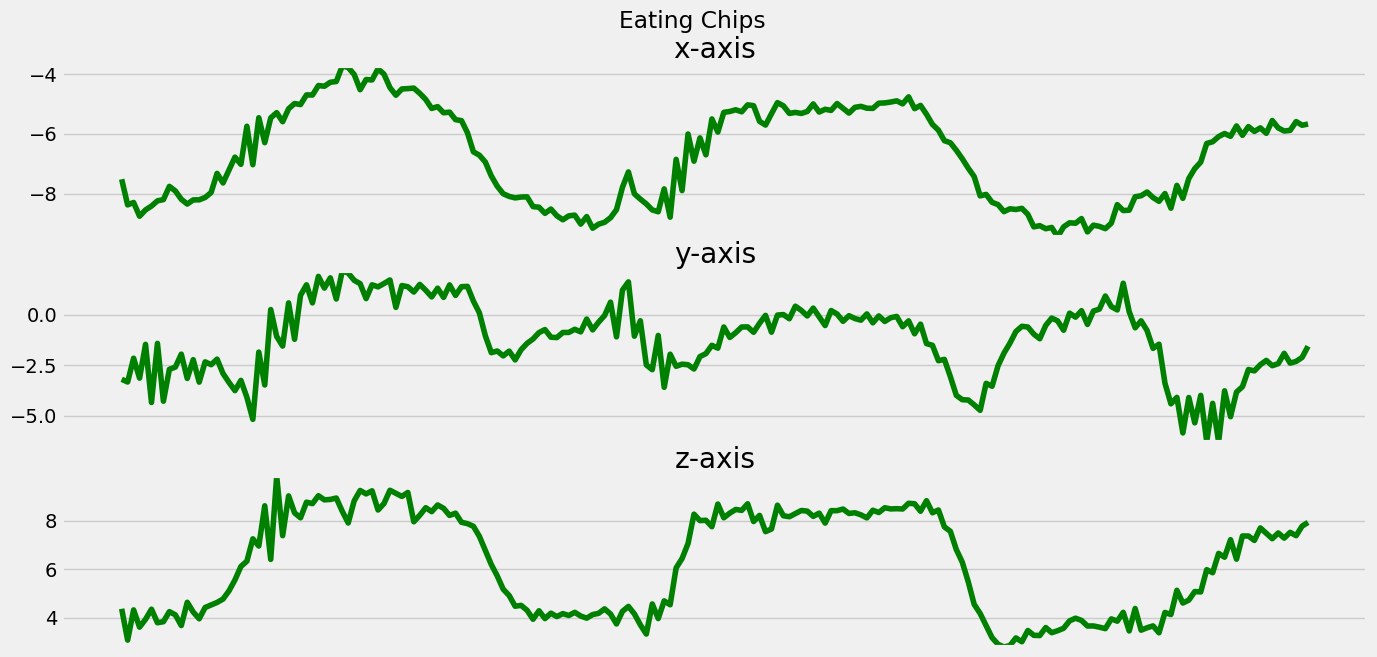

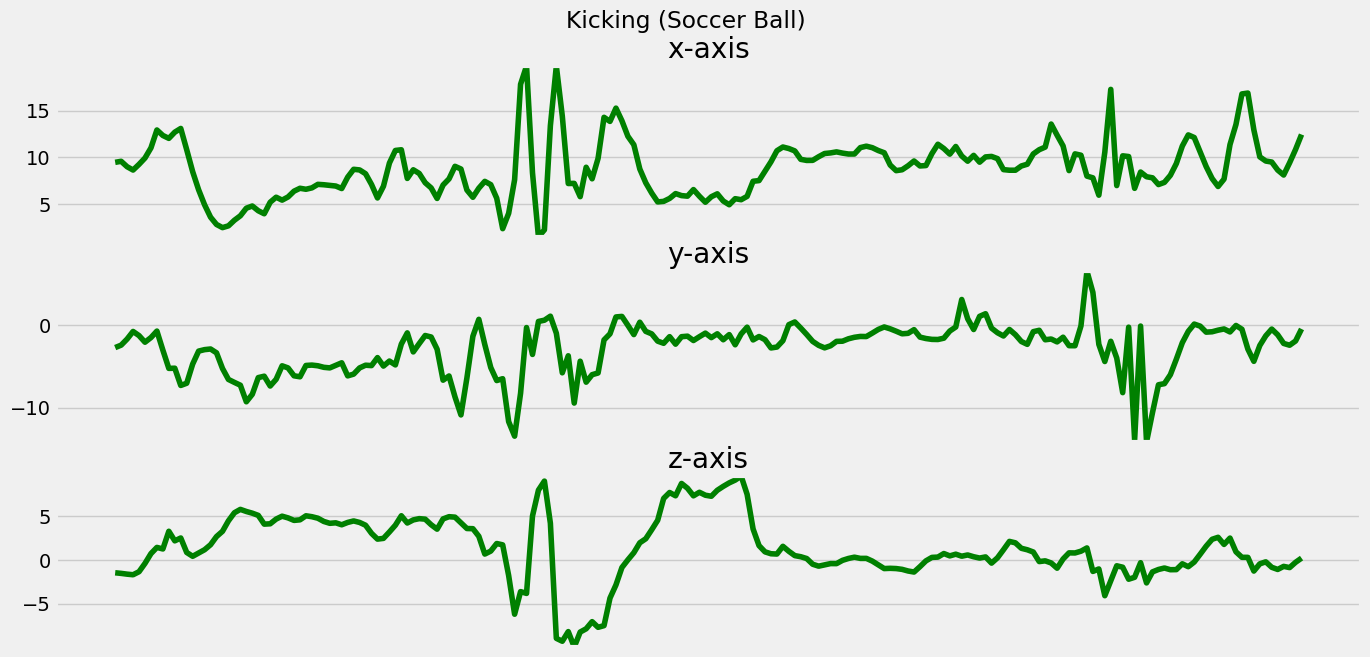

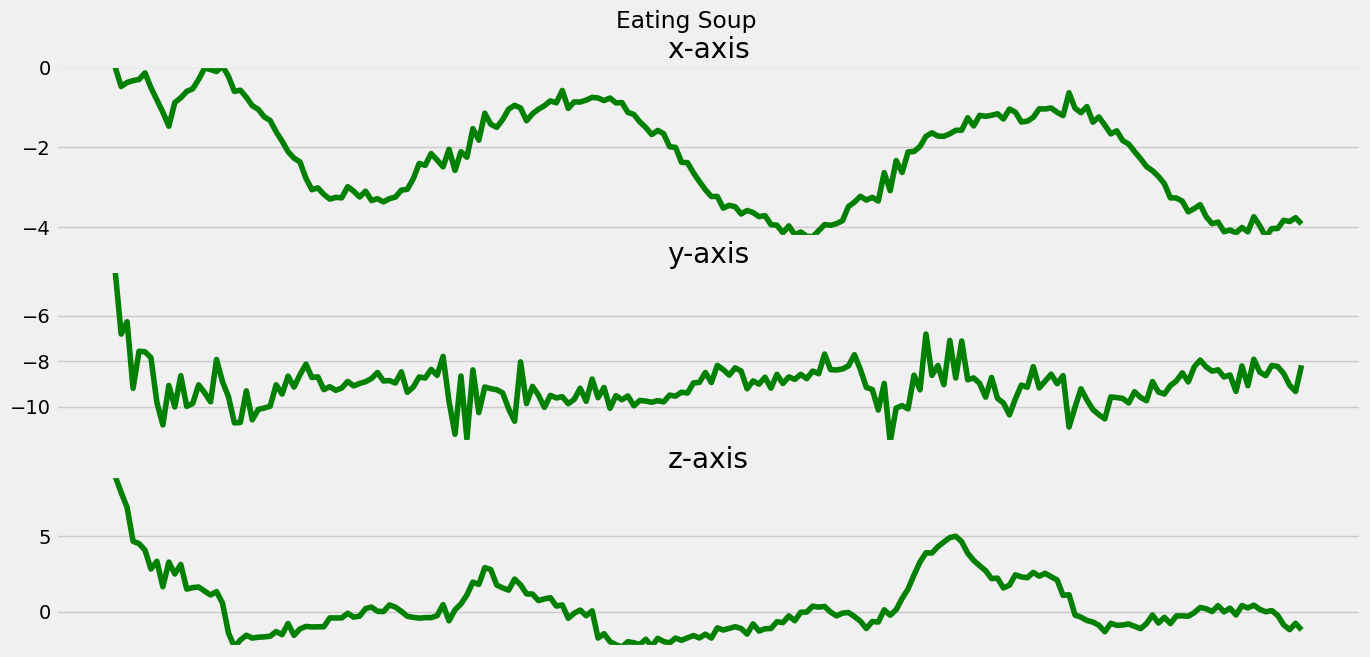

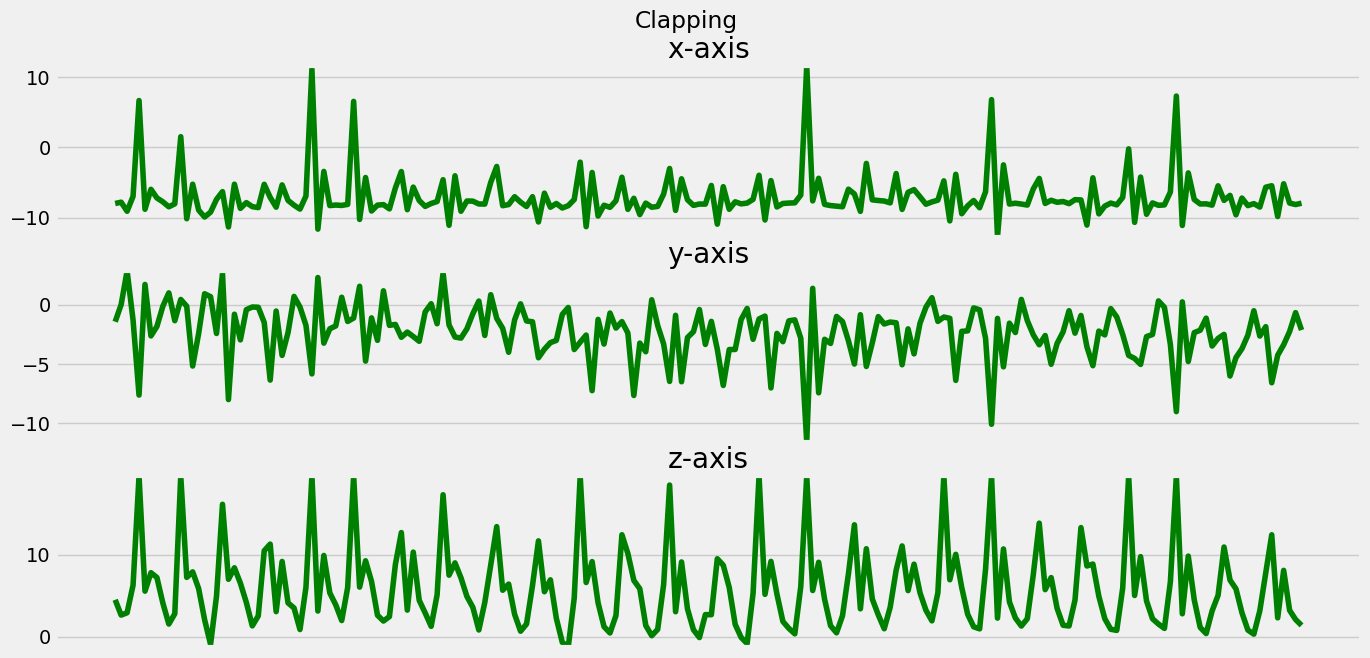

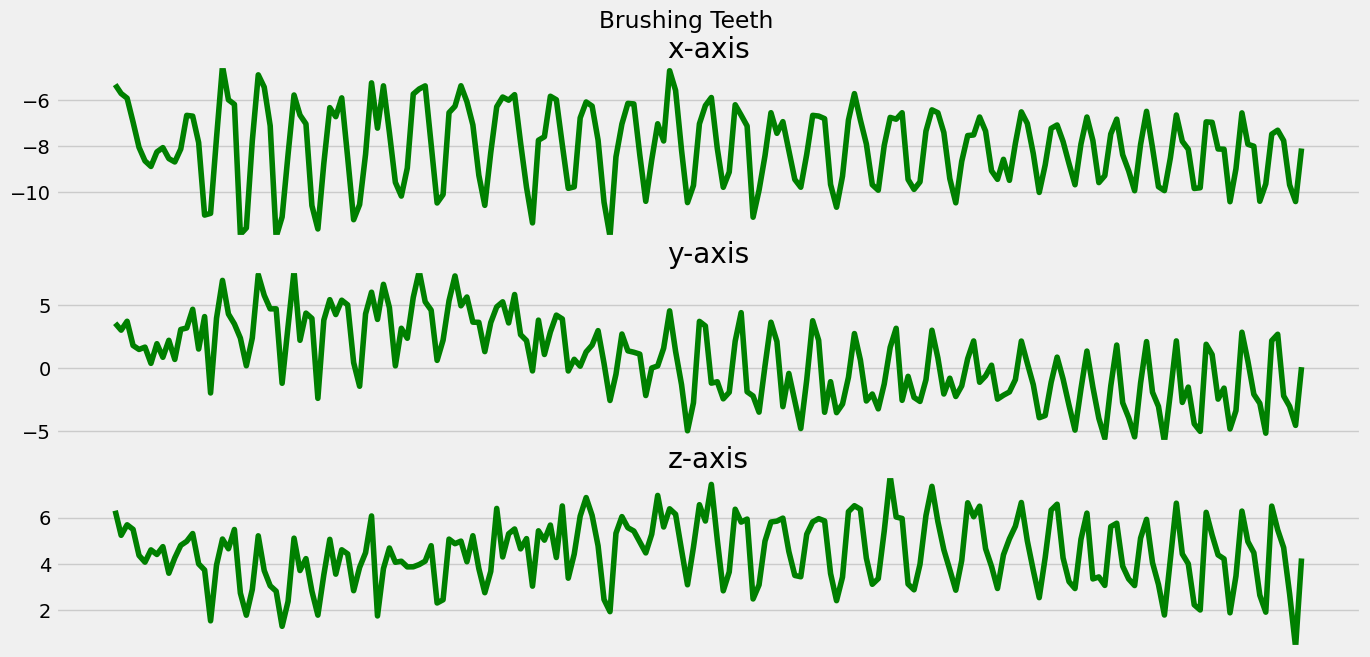

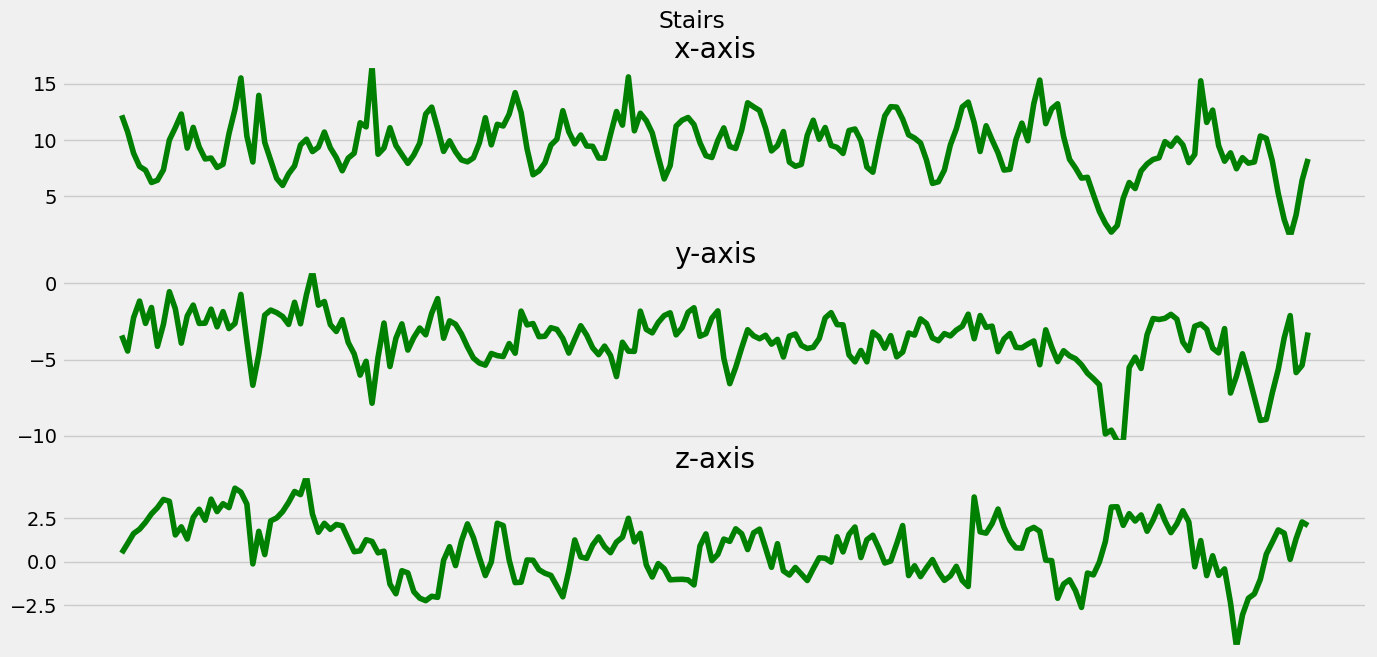

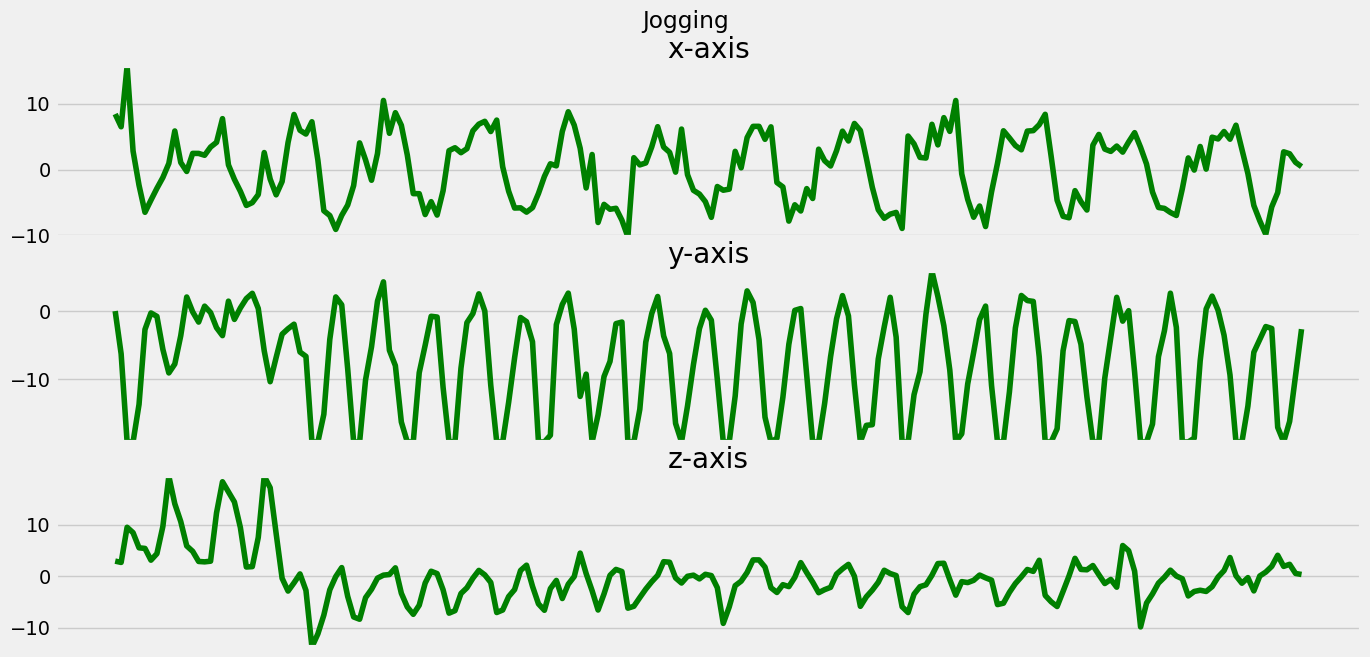

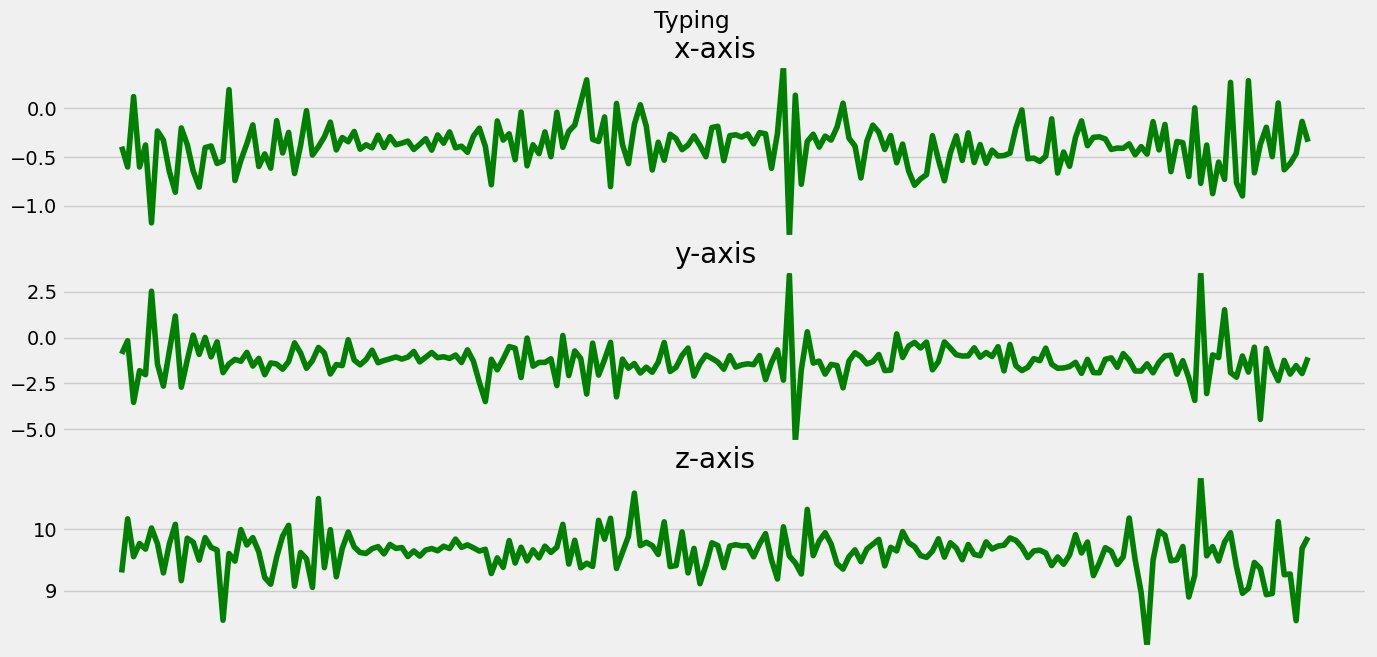

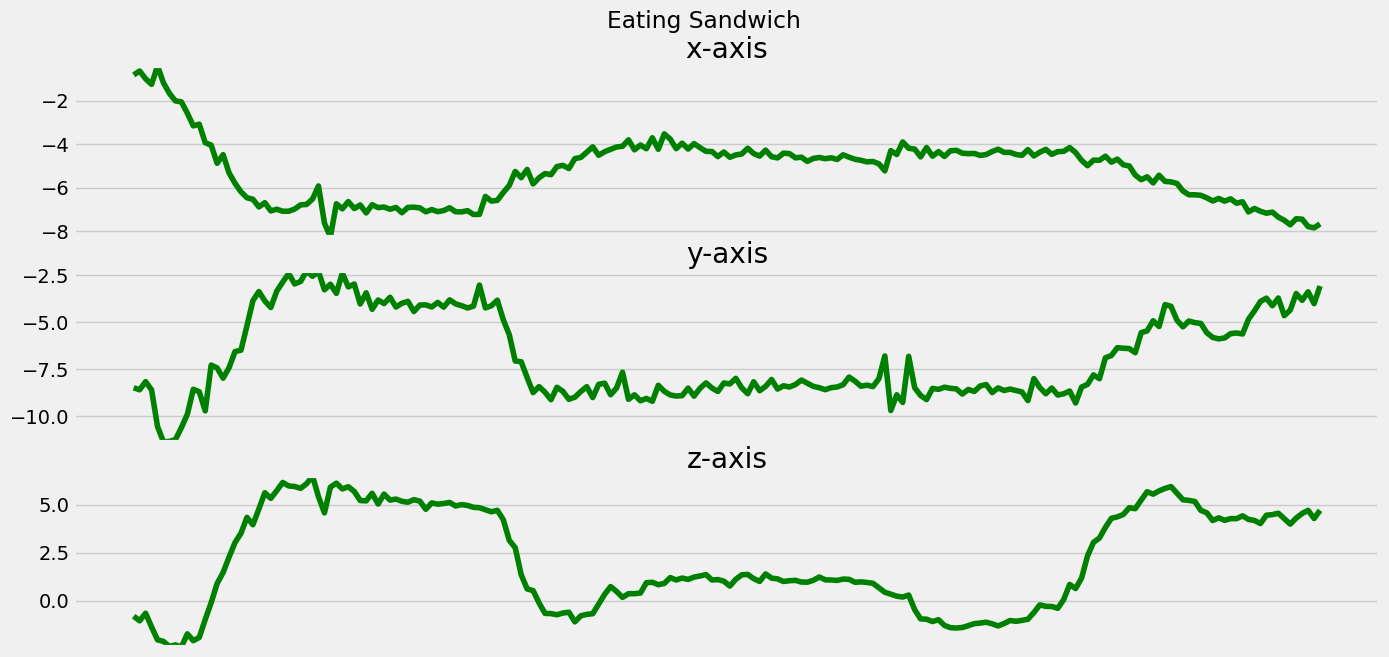

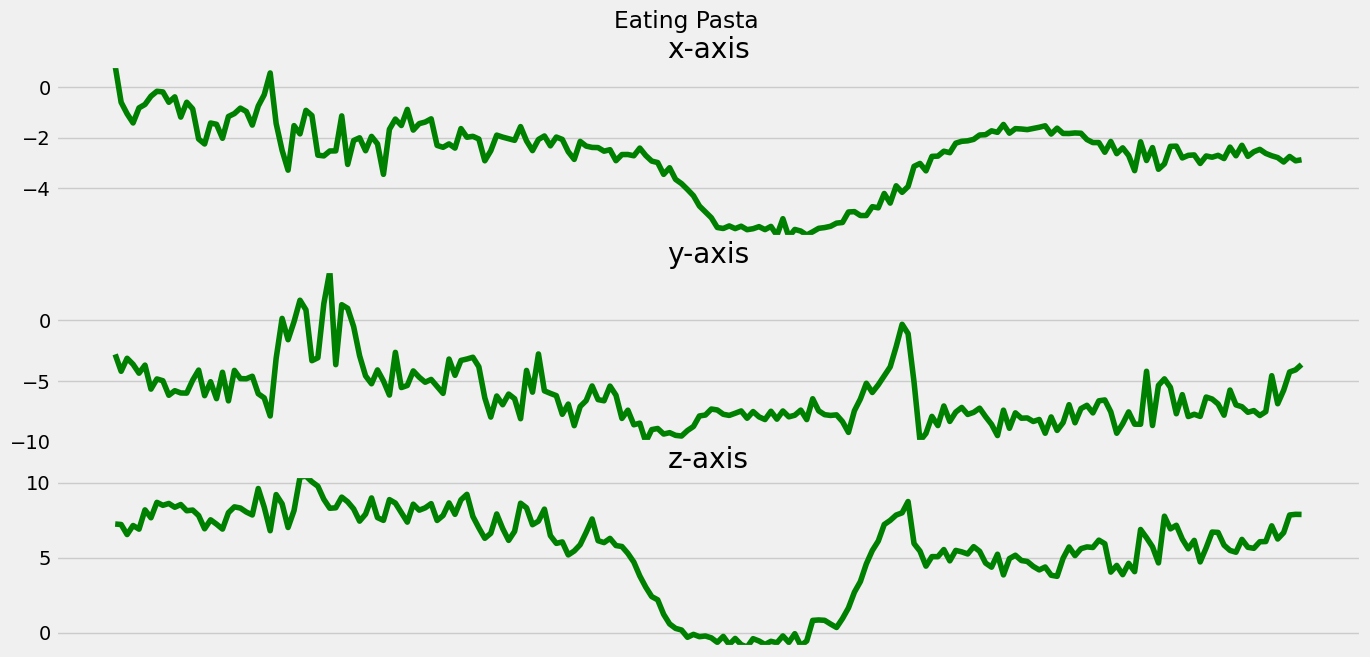

In [123]:
for activity in activities:
    data_for_plot = o_accel_watch_df[o_accel_watch_df['activities'] == activity][:Fs * 10]
    plot_activity(activity, data_for_plot)

Data Normalization and Encoding

In [124]:
label = LabelEncoder()
balanced_phone_data['labels'] = label.fit_transform(balanced_phone_data['labels'])  # transforms the labels into numbers
balanced_watch_data['labels'] = label.fit_transform(balanced_watch_data['labels'])

In [125]:
# Separating X from y
X_phone = balanced_phone_data[['x', 'y', 'z']]
y_phone = balanced_phone_data['labels']

X_watch = balanced_watch_data[['x', 'y', 'z']]
y_watch = balanced_watch_data['labels']

# Standardizing the data
scaler = StandardScaler()
X_phone = scaler.fit_transform(X_phone)
X_watch = scaler.fit_transform(X_watch)

# Creating another dataframe
scaled_X_phone = pd.DataFrame(data=X_phone, columns=['x', 'y', 'z'])
scaled_X_phone['labels'] = y_phone.values

scaled_X_watch = pd.DataFrame(data=X_watch, columns=['x', 'y', 'z'])
scaled_X_watch['labels'] = y_watch.values

## <span style="color:Orange;"> IV. Deep Learning </span>

Frame Preparation

In [147]:
# Frame Preparation
Fs = 20                                                 # Sensor polling rate
window_size = 4                 #100 samples           # Seconds required for predicting data
frame_size = Fs * window_size    #1,000                 # For dimension purposes
steps = Fs * 2                  

In [148]:
def get_frames(df, frame_size, steps):
    N_FEATURES = 3              # number of columns (x, y, z)
    frames = []
    labels = []

    for i in range(0, len(df) - frame_size, steps):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]

        # Retrieve the most often used label in this segment
        label = stats.mode(df['labels'][i: i + frame_size])[0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segment into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels       

Creating a model first on predicting the activity using the <span style="color: Orange;"> Phone Accelerometer </span>

In [149]:
X, y = get_frames(scaled_X_phone, frame_size, steps)

In [150]:
X.shape, y.shape 

((91399, 80, 3), (91399,))

In [151]:
(203112*18)/steps   # Making sure some of the variables set are correct

91400.4

Spltting the data into train and test

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [153]:
X_train.shape, X_test.shape 

((73119, 80, 3), (18280, 80, 3))

In [154]:
X_train[0].shape, X_test[0].shape 

((80, 3), (80, 3))

In [157]:
# reshaping the data to have an additional dimension
X_train = X_train.reshape(73119, 80, 3, 1)    #reshaping by getting the first index of X_train.shape and X_train[0].shape
X_test = X_test.reshape(18280, 80, 3, 1)

In [76]:
X_train[0].shape, X_test[0].shape 

((1000, 3, 1), (1000, 3, 1))

### Training the Model (Phone Accelerometer)

2D CNN Model (Attempt 1)

In [101]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16, (2, 2), activation='relu', input_shape = X_train[0].shape),
                                    tf.keras.layers.Dropout(0.1),
                                    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
                                    tf.keras.layers.Dropout(0.2),

                                    tf.keras.layers.Flatten(),

                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dropout(0.5),

                                    tf.keras.layers.Dense(18, activation='softmax')
                                    ])

In [102]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [103]:
history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.1055 - loss: 2.7924 - val_accuracy: 0.2022 - val_loss: 2.2568
Epoch 2/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.1775 - loss: 2.3793 - val_accuracy: 0.2617 - val_loss: 2.1123
Epoch 3/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - accuracy: 0.1996 - loss: 2.2320 - val_accuracy: 0.2738 - val_loss: 2.0254
Epoch 4/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.2347 - loss: 2.1308 - val_accuracy: 0.2827 - val_loss: 1.9893
Epoch 5/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.2402 - loss: 2.0640 - val_accuracy: 0.2627 - val_loss: 2.0096
Epoch 6/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.2553 - loss: 2.0296 - val_accuracy: 0.2827 - val_loss: 1.9626
Epoch 7/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.2597 - loss: 2.0186 - val_accuracy: 0.2831 - val_loss: 1.9768
Epoch 8/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.2566 - loss: 2

In [105]:
def plot_learningCurve(history, epochs):
    # Plot training and validaiton accuracy values
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training and validaiton loss values
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

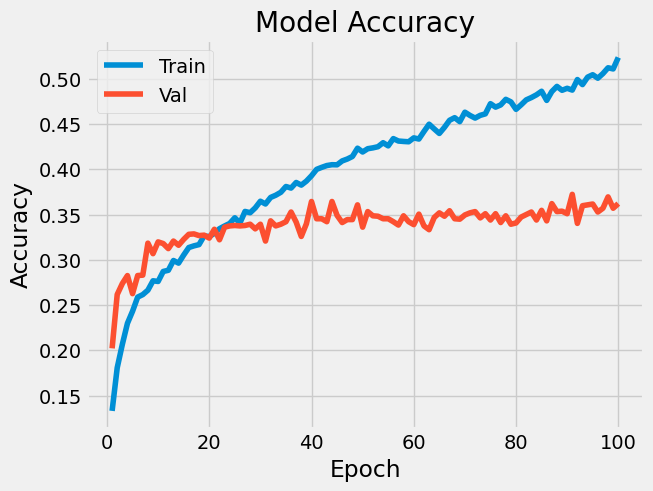

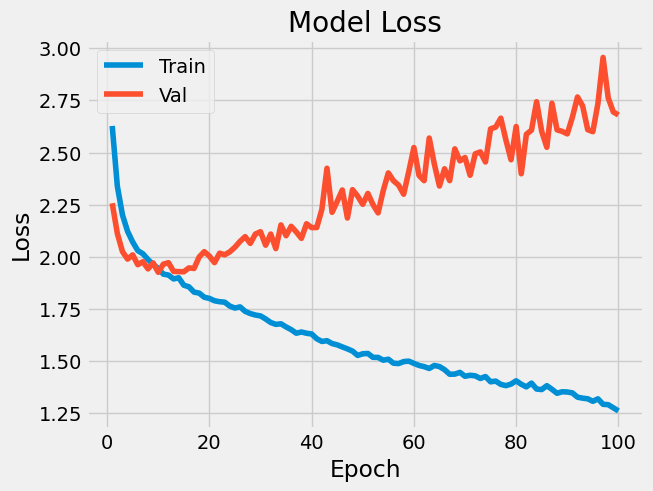

In [106]:
plot_learningCurve(history, 100)

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

### Confusion Matrix
If the color is mostly concentrated around the diagonal line (i.e. <span style="color:Blue;"> A </span> of true label and <span style="color:Blue;"> A </span> of predicted label has the strongest color), the model has a better accuracy rate

In [107]:
y_pred = model.predict(X_test)

# Transforms the y_pred into a discrete label
y_pred = np.argmax(y_pred, axis=1)

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

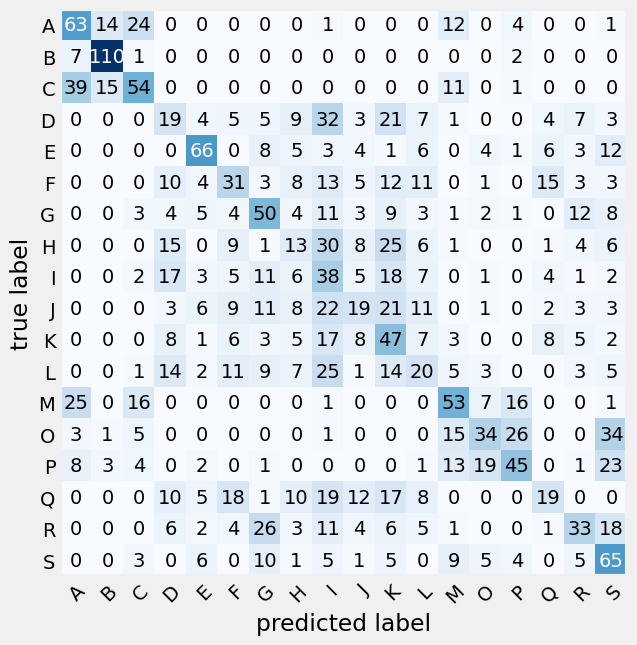

In [108]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=False, figsize=(7,7))

### 2D CNN Model (Attempt 2)

Frame Preparation

In [129]:
# Frame Preparation
Fs = 20                                                 # Sensor polling rate
window_size = 20                 #400 samples           # Seconds required for predicting data
frame_size = Fs * window_size    #8,000                 # For dimension purposes
steps = Fs * 10    

In [130]:
def get_frames(df, frame_size, steps):
    N_FEATURES = 3              # number of columns (x, y, z)
    frames = []
    labels = []

    for i in range(0, len(df) - frame_size, steps):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]

        # Retrieve the most often used label in this segment
        label = stats.mode(df['labels'][i: i + frame_size])[0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segment into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels       

Creating a model first on predicting the activity using the <span style="color: Orange;"> Phone Accelerometer </span>

In [131]:
X, y = get_frames(scaled_X_phone, frame_size, steps)

In [132]:
X.shape, y.shape 

((18279, 400, 3), (18279,))

In [133]:
(203112*18)/steps   # Making sure some of the variables set are correct

18280.08

Splitting the data into train and test

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [135]:
X_train.shape, X_test.shape 

((14623, 400, 3), (3656, 400, 3))

In [136]:
X_train[0].shape, X_test[0].shape 

((400, 3), (400, 3))

In [137]:
# reshaping the data to have an additional dimension
X_train = X_train.reshape(14623, 400, 3, 1)             #reshaping by getting the first index of X_train.shape and X_train[0].shape
X_test = X_test.reshape(3656, 400, 3, 1)

In [138]:
X_train[0].shape, X_test[0].shape

((400, 3, 1), (400, 3, 1))

### Training the Model (Phone Accelerometer)

2D CNN Model

In [139]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16, (2, 2), activation='relu', input_shape = X_train[0].shape),
                                    tf.keras.layers.Dropout(0.1),
                                    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
                                    tf.keras.layers.Dropout(0.2),

                                    tf.keras.layers.Flatten(),

                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dropout(0.5),

                                    tf.keras.layers.Dense(18, activation='softmax')
                                    ])

c:\Users\User\anaconda3\envs\NEW_ENV_NAME\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [140]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [141]:
history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.1336 - loss: 2.6363 - val_accuracy: 0.2763 - val_loss: 2.1124
Epoch 2/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.2356 - loss: 2.1716 - val_accuracy: 0.3017 - val_loss: 1.9559
Epoch 3/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.2710 - loss: 2.0426 - val_accuracy: 0.3115 - val_loss: 1.8889
Epoch 4/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.2857 - loss: 1.9667 - val_accuracy: 0.3178 - val_loss: 1.8668
Epoch 5/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.3049 - loss: 1.9272 - val_accuracy: 0.3121 - val_loss: 1.8705
Epoch 6/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.3103 - loss: 1.8947 - val_accuracy: 0.3386 - val_loss: 1.8005
Epoch 7/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.3221 - loss: 1.8430 - val_accuracy: 0.3548 - val_loss: 1.7781
Epoch 8/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.3285 - loss: 1

In [142]:
def plot_learningCurve(history, epochs):
    # Plot training and validaiton accuracy values
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training and validaiton loss values
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

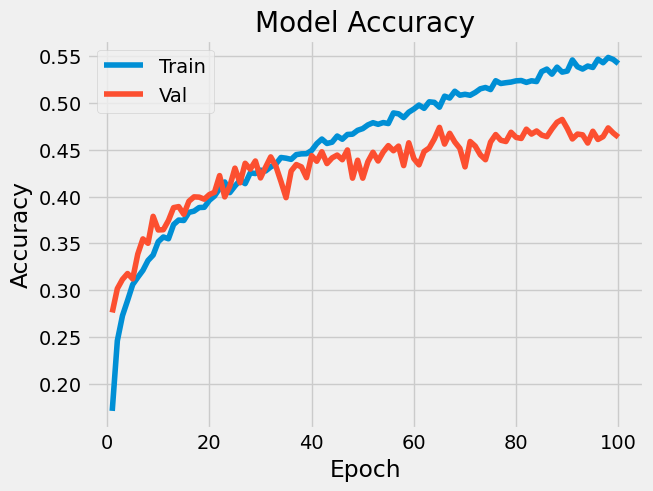

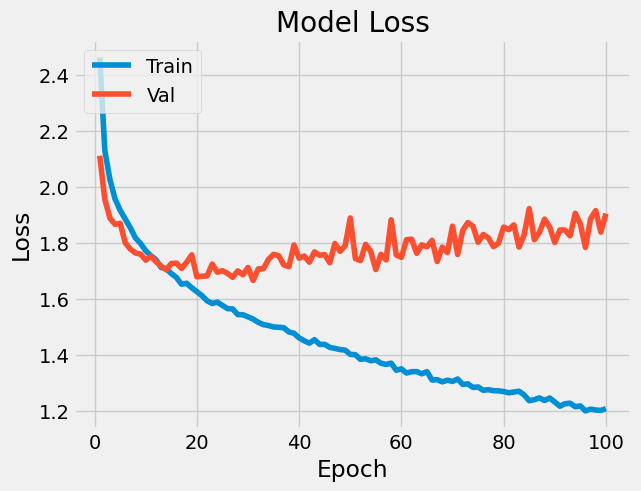

In [143]:
plot_learningCurve(history, 100)

In [144]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4571 - loss: 1.9459
Test Loss: 1.905733346939087, Test Accuracy: 0.4633479118347168


### Confusion Matrix
If the color is mostly concentrated around the diagonal line (i.e. <span style="color:Blue;"> A </span> of true label and <span style="color:Blue;"> A </span> of predicted label has the strongest color), the model has a better accuracy rate

In [145]:
y_pred = model.predict(X_test)

# Transforms the y_pred into a discrete label
y_pred = np.argmax(y_pred, axis=1)

115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

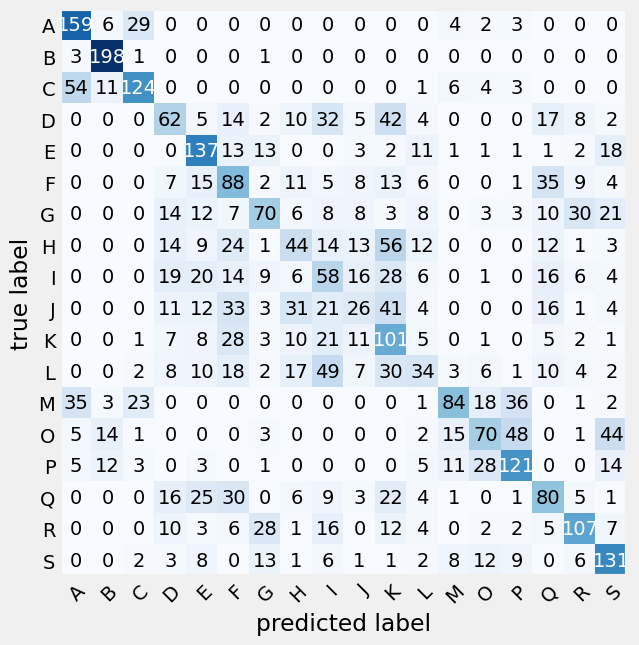

In [146]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=False, figsize=(7,7))

## <span style="color:Orange;"> V. Results and Discussion </span>
`text here`

## <span style="color:Orange;"> VI. Conclusion and Recommendation </span>
`text here`